In [2]:
# Analisis de datos
import pandas as pd
import numpy as np
import math

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats

# Fechas y Horas
import time
from datetime import date
from datetime import timedelta

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

# Propiedas y visualizacion
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Alertas
import warnings
warnings.filterwarnings("ignore")
    
# Configuraciones
pd.set_option('float_format', '{:,.2f}'.format) #Ajusta formato de números
pd.set_option('display.max_columns', None) #Muestra todas la columnas
pd.set_option('display.max_colwidth', None) #Mostrar el NUM_IDENT completo

### 0. Parámetros y Funciones de apoyo

In [3]:
# Funciones de Apoyo
# Función para mostrar las frecuencias absolutas y relativas de un campo
def volumetria(df,columna,orden):
    resultado = df.groupby([columna]).agg(Cantidad=(columna, 'count')).reset_index()
    total = resultado['Cantidad'].sum()
    resultado['% Total'] = (resultado['Cantidad'] / total) * 100
    if orden == 0:
        resultado = resultado.sort_values('% Total', ascending=False)
    elif orden == 1:
        resultado = resultado.sort_values(columna, ascending=True)
    else:
        return print('En orden solo puede escoger los valores 0,1')
    
    # Calcular el % Total Acumulado
    resultado['% Acumulado'] = resultado['% Total'].cumsum()
    return resultado

# Revision de Missings
def revision_missings(df):
    df_missings = pd.DataFrame({
        'COLUMNA': df.columns,
        'NRO_NULL': df.isna().sum(),
        '%_NULL': round(df.isna().mean() * 100, 2).astype(str) + '%'
    }).reset_index(drop=True)

    return df_missings

# Revision de Outliers General
def outliers_col(df):
    resultados = []
    for columna in df:
        if df[columna].dtype != object:
            q1 = stats.scoreatpercentile(df[columna].dropna(), 25)
            q3 = stats.scoreatpercentile(df[columna].dropna(), 75)
            iqr = q3 - q1
            lim_inf = q1 - 1.5 * iqr
            lim_sup = q3 + 1.5 * iqr
            n_outliers_inf = len(df[(df[columna] < lim_inf)])
            n_outliers_sup = len(df[(df[columna] > lim_sup)])
            resultados.append([df[columna].name, n_outliers_inf, n_outliers_sup])
    
    df_resultados = pd.DataFrame(resultados, columns=['NOMBRE_COLUMNA', 'NRO_OUTLIERS_INF', 'NRO_OUTLIERS_SUP'])
    return df_resultados

# Revision de Outliers Individual
def rev_outliers(df,campo):
    cantidad = df[campo].count()
    nulls = df[campo].isna().sum()
    unicos = df[campo].nunique()
    porc_nulls = round(nulls/ df.shape[0],4)*100
    print(f'Nro Filas: {cantidad:,}.')
    print(f'Nro Nulls: {nulls:,}. Un {porc_nulls}% son nulls.')
    print(f'Nro Valores Unicos: {unicos:,}.')

    print(f'\nDeciles de {campo}:')
    print(df[campo].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]))

    # Calcular los límites utilizando el rango intercuartílico (IQR)
    q1 = df[campo].quantile(0.25)
    q3 = df[campo].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr

    print(f'\nLímite superior: {round(upper_limit,2)} y Límite inferior: {round(lower_limit,2)}')
    print(f'Valor mínimo: {df[campo].min()}')
    print(f'Valor máximo: {df[campo].max()}')

    # Identificar los valores atípicos
    outliers = df[(df[campo] < lower_limit) | (df[campo] > upper_limit)]
    # Calcular la cantidad de outliers
    print(f'\nCantidad de outliers: {outliers.shape[0]} de {df.shape[0]}. Es un {round(outliers.shape[0]/df.shape[0],2)*100}%.')

    # Graficar el boxplot
    sns.boxplot(x=df[campo])
    # Agregar título al gráfico
    plt.title('Boxplot de '+campo)
    # Mostrar el gráfico
    plt.show()

def visualizar_kde(df, excluir_columnas, num_columnas=3, figsize=(15, 5)):
    # Filtrar las columnas que no están en la lista de exclusión
    columnas = df.drop(columns=excluir_columnas).columns

    # Definir el número de filas basado en las columnas
    num_filas = math.ceil(len(columnas) / num_columnas)

    # Crear la figura y los ejes
    fig, axes = plt.subplots(num_filas, num_columnas, figsize=(figsize[0], num_filas * figsize[1]))
    axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar el acceso

    # Iterar sobre cada columna y graficar en cada subgráfico
    for i, col in enumerate(columnas):
        sns.histplot(df[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribución de {col}')

    # Eliminar cualquier gráfico vacío si el número de columnas no es múltiplo exacto de filas * columnas
    for i in range(len(columnas), len(axes)):
        fig.delaxes(axes[i])

    # Ajustar el espacio entre los gráficos
    plt.tight_layout()
    plt.show()

# Función para limitar por la izquierda
def limitar_por_izquierda(df, columna, limite_inferior):
    df[columna][df[columna] < df[columna].quantile(limite_inferior)] = df[columna].quantile(limite_inferior)
    return df

# Función para limitar por la derecha
def limitar_por_derecha(df, columna, limite_superior):
    df[columna][df[columna] > df[columna].quantile(limite_superior)] = df[columna].quantile(limite_superior)
    return df

### 1. Importacion Data

In [33]:
directory_consolidado = 'C:/Users/BW439WF/Downloads/Datathon DMC/Datathon_DMC/data/03_interim/'
df_consolidado = pd.read_parquet(directory_consolidado + 'vars_compromisos_1.parquet')
# Resumen Data
#print(f'Nro Clientes: {df_consolidado["COD_CLIENTE"].nunique():,}')
print(f'Nro Filas: {df_consolidado.shape[0]:,}')
df_consolidado.head()

Nro Filas: 37,577


,CONTACTO_ID_COMPLETO,TOTAL_DONADO,CANTIDAD_CUOTAS_PAGADAS_GLOBAL,DONANTE_ACTIVO,COMPROMISO_ACTIVO,IMPORTE_DONACION_PROM_6M,IMPORTE_DONACION_PROM_9M,IMPORTE_DONACION_PROM_12M,IMPORTE_DONACION_PROM_24M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_6M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_9M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_24M,NUMERO_CUOTAS_PROM_6M,NUMERO_CUOTAS_PROM_9M,NUMERO_CUOTAS_PROM_12M,NUMERO_CUOTAS_PROM_24M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_6M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_9M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_24M,DONANTE_ACTIVO_right,RECENCIA_DONACION,ANTIGUEDAD_PRIMER_PAGO,ANTIGUEDAD_PRIMER_DONACION,DIFERENCIA_PRIMER_ULTIMO_PAGO,NUM_BAJAS,NUM_FECHAS_ESTABLECIDAS,ANTIGUEDAD_DIAS,FECHA_ESTABLECIDA,TIPO_COMPROMISO,TIPO_REGISTRO,FRECUENCIA,MEDIO_PAGO,ENTIDAD_COBRADORA,TIPO_CUENTA,TIPO_TARJETA,BANCO_EMISOR,CANAL_CAMPANA,CODIGO_AUDITORIA,CAMPANA_ACTIVIDAD,CAMPANA_FIDELIZACION,CODIGO_UBICACION,PUNTO_CAPTACION,TIPO_BAJA,MOTIVO_BAJA
0,003UX00000I33INYAZ,0.00,0,0,0,10.00,10.00,10.00,10.00,6.00,6.00,6.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-02-19,Primer Compromiso,DI - Regular,Mensual,Tarjeta de Crédito,NaN,NaN,Otros,NaN,F2F,RF-F2F02,F2F CHICLAYO IF4C 2025,NaN,NaN,RIPLEY PIURA,NaN,NaN
1,003UX00000I33AHYAZ,0.00,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,1,25,2025-04-30,Primer Compromiso,DI - Regular,Mensual,Débito Automático,Interbank,Ahorros,NaN,NaN,F2F,RF-F2F01,F2F CLASICO LIMA 2025,NaN,NaN,PLAZA VEA LA BOLICHERA,NaN,NaN
2,003UX00000I2y49YAB,0.00,0,0,0,10.00,10.00,10.00,10.00,6.00,6.00,6.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-02-19,Primer Compromiso,DI - Regular,Mensual,Débito Automático,Scotiabank,Ahorros,NaN,NaN,F2F,RF-F2F02,F2F CHICLAYO IF4C 2025,NaN,NaN,RIPLEY PIURA,NaN,NaN
3,003UX00000I2xssYAB,0.00,0,0,0,30.00,30.00,30.00,30.00,5.00,5.00,5.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-03-31,Primer Compromiso,DI - Regular,Mensual,Tarjeta de Débito,NaN,NaN,Visa Débito,INTERBANK,Telemarketing,AF7.1RETMK,TELEMARKETING 2025,NaN,Lima,BASE - 102,NaN,NaN
4,003UX00000I2tECYAZ,0.00,0,0,0,100.00,100.00,100.00,100.00,6.00,6.00,6.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-02-25,Primer Compromiso,PI - Padrinazgo individual,Mensual,Débito Automático,Banco de Crédito del Perú,Ahorros,NaN,NaN,Telemarketing,AF7.1RETMK,TELEMARKETING 2025,NaN,Lima,BASE - 104,NaN,NaN


In [ ]:
import unidecode  # Asegura que tienes instalada esta librería con: pip install unidecode
directory_contactos = "C:/Users/BW439WF/Downloads/Datathon DMC/Datathon_DMC/data/02_raw/"
df_contactos = pd.read_excel(directory_contactos + 'BBDD_CONTACTOS.xlsx')

# Función para limpiar nombres de columnas
def clean_column_names(columns):
    return [unidecode.unidecode(col.upper().replace(" ", "_")) for col in columns]

# Aplicar la función a las columnas del DataFrame
df_contactos.columns = clean_column_names(df_contactos.columns)

# Resumen Data
print(f'Nro Clientes: {df_contactos["ID_COMPLETO"].nunique():,}')
print(f'Nro Filas: {df_contactos.shape[0]:,}')
df_contactos.head()

Nro Clientes: 147,513
Nro Filas: 147,513


,ID_COMPLETO,PAIS_DE_CORREO,ESTADO_O_PROVINCIA_DE_CORREO,CODIGO_POSTAL_DE_CORREO,CIUDAD_DE_CORREO,NOMBRE,GENERO,TRATAMIENTO,ESTADO_CIVIL,TIENE_HIJOS,HOBBIE,TIENE_NIETOS,NIVEL_DE_ESTUDIOS,TRABAJA_ACTUALMENTE,OCUPACION
0,0031R00001uhz7IQAQ,Perú,Lima,Lima,San Borja,Gledy Georgina,Femenino,Srita.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0031R0000281tkvQAA,Perú,Lima,Lima,San Borja,Fredy Enrique,Masculino,Sr.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0031R00002KqNYbQAN,Perú,Lima,Lima,Santiago De Surco,Alvaro Patricio,Masculino,Sr.,Soltero/a?,No,NaN,NaN,NaN,NaN,NaN
3,0031R00002hJzb5QAC,Perú,Lambayeque,Chiclayo,Chiclayo,Anton Cesar,Masculino,Sr.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0033600001ADzauAAD,Perú,Lima,Lima,Comas,Diana Alison Milagros,Femenino,Sra.,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df_consolidado_final = df_consolidado.merge(df_contactos, how='inner', left_on=['CONTACTO_ID_COMPLETO'], right_on=['ID_COMPLETO'])

# Resumen Data
print(f'Nro Clientes: {df_consolidado_final["ID_COMPLETO"].nunique():,}')
print(f'Nro Filas: {df_consolidado_final.shape[0]:,}')
df_consolidado_final.head()

Nro Clientes: 37,572
Nro Filas: 37,572


,CONTACTO_ID_COMPLETO,TOTAL_DONADO,CANTIDAD_CUOTAS_PAGADAS_GLOBAL,DONANTE_ACTIVO,COMPROMISO_ACTIVO,IMPORTE_DONACION_PROM_6M,IMPORTE_DONACION_PROM_9M,IMPORTE_DONACION_PROM_12M,IMPORTE_DONACION_PROM_24M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_6M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_9M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_24M,NUMERO_CUOTAS_PROM_6M,NUMERO_CUOTAS_PROM_9M,NUMERO_CUOTAS_PROM_12M,NUMERO_CUOTAS_PROM_24M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_6M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_9M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_24M,DONANTE_ACTIVO_right,RECENCIA_DONACION,ANTIGUEDAD_PRIMER_PAGO,ANTIGUEDAD_PRIMER_DONACION,DIFERENCIA_PRIMER_ULTIMO_PAGO,NUM_BAJAS,NUM_FECHAS_ESTABLECIDAS,ANTIGUEDAD_DIAS,FECHA_ESTABLECIDA,TIPO_COMPROMISO,TIPO_REGISTRO,FRECUENCIA,MEDIO_PAGO,ENTIDAD_COBRADORA,TIPO_CUENTA,TIPO_TARJETA,BANCO_EMISOR,CANAL_CAMPANA,CODIGO_AUDITORIA,CAMPANA_ACTIVIDAD,CAMPANA_FIDELIZACION,CODIGO_UBICACION,PUNTO_CAPTACION,TIPO_BAJA,MOTIVO_BAJA,ID_COMPLETO,PAIS_DE_CORREO,ESTADO_O_PROVINCIA_DE_CORREO,CODIGO_POSTAL_DE_CORREO,CIUDAD_DE_CORREO,NOMBRE,GENERO,TRATAMIENTO,ESTADO_CIVIL,TIENE_HIJOS,HOBBIE,TIENE_NIETOS,NIVEL_DE_ESTUDIOS,TRABAJA_ACTUALMENTE,OCUPACION
0,003UX00000I2dSlYAJ,0.00,0,0,0,5.00,5.00,5.00,5.00,6.00,6.00,6.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-02-19,Primer Compromiso,DI - Regular,Mensual,Tarjeta de Crédito,NaN,NaN,Otros,NaN,F2F,RF-F2F01,F2F CLASICO LIMA 2025,NaN,NaN,PLAZA VEA CENTRO CIVICO,NaN,NaN,003UX00000I2dSlYAJ,Perú,NaN,NaN,NaN,Indhira,Femenino,Sra.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,003UX00000I2bSXYAZ,0.00,0,0,0,20.00,20.00,20.00,20.00,6.00,6.00,6.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-02-19,Primer Compromiso,DI - Regular,Mensual,Tarjeta de Crédito,NaN,NaN,Otros,NaN,F2F,RF-F2F01,F2F CLASICO LIMA 2025,NaN,NaN,MALL AVENTURA IQUITOS,NaN,NaN,003UX00000I2bSXYAZ,Perú,Loreto,NaN,NaN,Emilia,Femenino,Sra.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,003UX00000I2VWpYAN,0.00,0,0,0,20.00,20.00,20.00,20.00,6.00,6.00,6.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-02-19,Primer Compromiso,DI - Regular,Mensual,Débito Automático,Banco de Crédito del Perú,Ahorros,NaN,NaN,F2F,RF-F2F01,F2F CLASICO LIMA 2025,NaN,NaN,MALL AVENTURA IQUITOS,NaN,NaN,003UX00000I2VWpYAN,Perú,NaN,NaN,NaN,Brendia,Femenino,Sra.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,003UX00000I2VWoYAN,0.00,0,0,0,30.00,30.00,30.00,30.00,5.00,5.00,5.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-03-03,Primer Compromiso,DI - Regular,Mensual,Débito Automático,Interbank,Ahorros,NaN,NaN,F2F,RF-F2F01,F2F CLASICO LIMA 2025,NaN,NaN,MALL AVENTURA IQUITOS,NaN,NaN,003UX00000I2VWoYAN,Perú,Loreto,NaN,NaN,Jhon,Masculino,Sr.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,003UX00000I2PGCYA3,0.00,0,0,0,30.00,30.00,30.00,30.00,6.00,6.00,6.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-02-19,Primer Compromiso,DI - Regular,Mensual,Tarjeta de Crédito,NaN,NaN,Otros,NaN,F2F,RF-F2F01,F2F CLASICO LIMA 2025,NaN,NaN,MALL AVENTURA IQUITOS,NaN,NaN,003UX00000I2PGCYA3,Perú,NaN,NaN,NaN,Cristhoper,Masculino,Sr.,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
df_consolidado_final.to_csv('vars_compromisos_2.csv', sep=";", index=False, encoding='LATIN-1')

In [12]:
directory_grupo_economico = "C:/Users/BW439WF/EY/BANRESERVAS_-_PRO - General/PRICING 2024/01. RFI/4. Solicitudes adicionales/19. Grupo Económico/"
df_grupo_economico = pd.read_excel(directory_grupo_economico + 'Grupo Economico.xlsx')

df_grupo_economico['CUSTOMER_SK'] = df_grupo_economico['CUSTOMER_SK'].astype(str)

# Resumen Data
print(f'Nro Clientes: {df_grupo_economico["CUSTOMER_SK"].nunique():,}')
print(f'Nro Filas: {df_grupo_economico.shape[0]:,}')
df_grupo_economico.head()

Nro Clientes: 1,192
Nro Filas: 1,285


,CUSTOMER_SK,GROUP_NAME,IDSEGMENTO,MAX_IDSEGMENTO
0,1056239,GRUPO EMPRESARIAL MEDITERRANEO,10,14
1,1530006,GRUPO COLCHONERIA,5,14
2,56752,GRUPO COLCHONERIA,3,14
3,280810,GRUPO COLCHONERIA,5,14
4,28306,GRUPO BANRESERVAS,5,14


In [13]:
df_bal_desembolsos = df_desembolsos.groupby(['COD_CLIENTE']).agg(
    NRO_DESEMBOLSOS = ('COD_CLIENTE', 'count'),
    SUM_DESEMBOLSOS = ('TOTAL_AMT_DISBURSED', 'sum'),
    SUM_TASA_X_DESEMBOLSO = ('TASA_X_MONTO', 'sum')
).reset_index() 
df_bal_desembolsos['TASA_PONDERADA'] = df_bal_desembolsos['SUM_TASA_X_DESEMBOLSO'] / df_bal_desembolsos['SUM_DESEMBOLSOS']
df_bal_desembolsos

,COD_CLIENTE,NRO_DESEMBOLSOS,SUM_DESEMBOLSOS,SUM_TASA_X_DESEMBOLSO,TASA_PONDERADA
0,10005225,1,"181,585,000.00","1,634,265,000.00",9.00
1,10014931,2,"23,817,453.87","299,385,395.15",12.57
2,10014957,1,"500,000,000.00","6,000,000,000.00",12.00
3,10016003,12,"152,800,000.00","2,091,560,000.00",13.69
4,10022874,3,"10,000,000.00","132,900,000.00",13.29
...,...,...,...,...,...
512,7467442,3,"5,140,000.00","62,710,000.00",12.20
513,7473443,2,"200,000,000.00","2,400,000,000.00",12.00
514,7485752,1,"9,799,924.90","115,835,112.32",11.82
515,7517330,1,"2,150,000.00","32,250,000.00",15.00


In [ ]:
directory_input = "C:/Users/BW439WF/EY/BANRESERVAS_-_PRO - General/PRICING 2024/04. Trabajo y Analisis/2. Analytics/5. Clustering/"
nombre_columnas_cluster = ['CUSTOMER_SK', 'FECHA_INGRESO', 'INGRESO_RIESGO', 'INGRESO_ESTIMADO', 'EDAD', 'SEXO', 'ESTADOCIVIL', 'STATE', 'IDSEGMENTO', 'SEGMENTO_BANCA', 
                           'OFICINA_PRINCIPAL', 'REGION_OFICINA_PRINCIPAL', 'PAIS_RESIDENCIA', 'TIPO_PERSONA', 'CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL', 'CANTIDAD_PRODUCTOS_ACTIVOS_UNICOS', 
                           'ANTIGUEDAD_CLIENTE_DIAS', 'MONTO_DESEMB_PROM_PR_PERSONAL_ULT_12_MESES', 'MONTO_DESEMB_PROM_PR_COMERCIAL_ULT_12_MESES', 'MONTO_DESEMB_TOTAL_PR_PERSONAL_ULT_12_MESES', 
                           'MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES', 'CANTIDAD_DESEMB_TOTAL_PR_PERSONAL_ULT_12_MESES', 'CANTIDAD_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES', 'DEUDA_TOTAL_PERSONAL', 
                           'DEUDA_TOTAL_COMERCIAL', 'SALDO_TOTAL_PROM_ACTIVAS_PERSONAL_ULT_12MESES', 'SALDO_TOTAL_PROM_ACTIVAS_COMERCIAL_ULT_12MESES', 'SALDO_TOTAL_PROM_PASIVAS_PERSONAL_ULT_12MESES', 
                           'SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES', 'MARGEN_PROM_ULT_12M', 'ACTIVAS_MARGEN_PROM_ULT_12M', 'PASIVAS_MARGEN_PROM_ULT_12M', 'CANTIDAD_ACTIVAS_SIS_FINANCIERO', 
                           'CANTIDAD_INSTITUCIONES_FINANCIERAS', 'TOTAL_DESEMB_PR_SIST_FINANC', 'TOTAL_ADEUDADO_TC_SIST_FINANC', 'SALDO_TOTAL_ACTIVAS_PERSONAL_ULT_12MESES', 'SALDO_TOTAL_ACTIVAS_COMERCIAL_ULT_12MESES', 
                           'SUM_BP_BRRD_ULT_12M_PR_CONS', 'PROM_BP_BRRD_ULT_12M_PR_CONS', 'SUM_BP_BRRD_ULT_12M_PR_COMER', 'PROM_BP_BRRD_ULT_12M_PR_COMER', 'SUM_BP_BRRD_ULT_12M_PR_HIPO', 'PROM_BP_BRRD_ULT_12M_PR_HIPO', 
                           'SUM_BP_BRRD_ULT_12M_TC_ROT', 'PROM_BP_BRRD_ULT_12M_TC_ROT', 'SUM_BP_BRRD_ULT_12M_TC_CREDI', 'PROM_BP_BRRD_ULT_12M_TC_CREDI', 'SUM_BP_BRRD_ULT_12M_CA', 'PROM_BP_BRRD_ULT_12M_CA', 
                           'SUM_BP_BRRD_ULT_12M_CC', 'PROM_BP_BRRD_ULT_12M_CC', 'SUM_BP_BRRD_ULT_12M_CD', 'PROM_BP_BRRD_ULT_12M_CD', 'CLIENTE_ACTIVO', 'RANGO_INGRESO', 'MAX_DIAS_ATRASO_PR', 'PROM_TRANS_ULT_12M_TUBANCO', 
                           'PROM_TRANS_ULT_12M_APP', 'PROM_TRANS_ULT_12M_SAB', 'PROM_TRANS_ULT_12M_IVR', 'PROM_TRANS_ULT_12M_M960', 'PROM_TRANS_ULT_12M_TPAGO', 'PROM_TRANS_ULT_12M_ATM', 'PROM_TRANS_ULT_12M_POS', 
                           'PROM_TRANS_ULT_12M_CAJA', 'PROM_MENS_ULT_24M_DEPOSITOS', 'NRO_MESES_REVOLVENCIA_ULT_12M', 'PROM_MENS_LC_TARJETA_CREDITO_ULT_12M', 'PROM_MENS_LC_TARJETA_CREDITO_ULT_12M_DOP', 
                           'PROM_MENS_LC_TARJETA_CREDITO_ULT_12M_USD', 'CODIGO_CIU', 'CIU', 'CODIGO_SECTOR', 'SECTOR_ECONOMICO', 'SUM_GANANCIAS_12M', 'SUM_PROVISION_CONSTITUIDA_12M', 'SUM_COMISIONES_12M', 
                           'PROM_SCORE_INTERNO', 'PROM_BALANCE_PR_BANRESERVAS_12M_PERSONAL', 'PROM_BALANCE_TC_BANRESERVAS_12M_PERSONAL', 'PROM_BALANCE_PR_COMPETENCIA_12M_PERSONAL', 'PROM_BALANCE_TC_COMPETENCIA_12M_PERSONAL', 
                           'PROM_BALANCE_PR_BANRESERVAS_12M_COMERCIAL', 'PROM_BALANCE_TC_BANRESERVAS_12M_COMERCIAL', 'PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL', 'PROM_BALANCE_TC_COMPETENCIA_12M_COMERCIAL', 
                           'PROM_SOW_PRESTAMOS_12M_PERSONAL', 'PROM_SOW_TC_12M_PERSONAL', 'PROM_SOW_TOTAL_12M_PERSONAL', 'PROM_SOW_PRESTAMOS_12M_COMERCIAL', 'PROM_SOW_TC_12M_COMERCIAL', 'PROM_SOW_TOTAL_12M_COMERCIAL', 'INDES_ULT_6_MES']

df_inicial = pd.read_csv(directory_input + 'Base general V7 EMP 21.11.2024.csv', sep=';', engine='pyarrow', encoding='UTF-8', names=nombre_columnas_cluster, header=None)

# Resumen Data
print(f'Nro Clientes: {df_inicial["CUSTOMER_SK"].nunique():,}')
print(f'Nro Columnas: {df_inicial.shape[1]:,}')
print(f'Nro Filas: {df_inicial.shape[0]:,}')
df_inicial.head(3)

Nro Clientes: 4,378
Nro Columnas: 94
Nro Filas: 4,400


,CUSTOMER_SK,FECHA_INGRESO,INGRESO_RIESGO,INGRESO_ESTIMADO,EDAD,SEXO,ESTADOCIVIL,STATE,IDSEGMENTO,SEGMENTO_BANCA,OFICINA_PRINCIPAL,REGION_OFICINA_PRINCIPAL,PAIS_RESIDENCIA,TIPO_PERSONA,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,CANTIDAD_PRODUCTOS_ACTIVOS_UNICOS,ANTIGUEDAD_CLIENTE_DIAS,MONTO_DESEMB_PROM_PR_PERSONAL_ULT_12_MESES,MONTO_DESEMB_PROM_PR_COMERCIAL_ULT_12_MESES,MONTO_DESEMB_TOTAL_PR_PERSONAL_ULT_12_MESES,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,CANTIDAD_DESEMB_TOTAL_PR_PERSONAL_ULT_12_MESES,CANTIDAD_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,DEUDA_TOTAL_PERSONAL,DEUDA_TOTAL_COMERCIAL,SALDO_TOTAL_PROM_ACTIVAS_PERSONAL_ULT_12MESES,SALDO_TOTAL_PROM_ACTIVAS_COMERCIAL_ULT_12MESES,SALDO_TOTAL_PROM_PASIVAS_PERSONAL_ULT_12MESES,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,MARGEN_PROM_ULT_12M,ACTIVAS_MARGEN_PROM_ULT_12M,PASIVAS_MARGEN_PROM_ULT_12M,CANTIDAD_ACTIVAS_SIS_FINANCIERO,CANTIDAD_INSTITUCIONES_FINANCIERAS,TOTAL_DESEMB_PR_SIST_FINANC,TOTAL_ADEUDADO_TC_SIST_FINANC,SALDO_TOTAL_ACTIVAS_PERSONAL_ULT_12MESES,SALDO_TOTAL_ACTIVAS_COMERCIAL_ULT_12MESES,SUM_BP_BRRD_ULT_12M_PR_CONS,PROM_BP_BRRD_ULT_12M_PR_CONS,SUM_BP_BRRD_ULT_12M_PR_COMER,PROM_BP_BRRD_ULT_12M_PR_COMER,SUM_BP_BRRD_ULT_12M_PR_HIPO,PROM_BP_BRRD_ULT_12M_PR_HIPO,SUM_BP_BRRD_ULT_12M_TC_ROT,PROM_BP_BRRD_ULT_12M_TC_ROT,SUM_BP_BRRD_ULT_12M_TC_CREDI,PROM_BP_BRRD_ULT_12M_TC_CREDI,SUM_BP_BRRD_ULT_12M_CA,PROM_BP_BRRD_ULT_12M_CA,SUM_BP_BRRD_ULT_12M_CC,PROM_BP_BRRD_ULT_12M_CC,SUM_BP_BRRD_ULT_12M_CD,PROM_BP_BRRD_ULT_12M_CD,CLIENTE_ACTIVO,RANGO_INGRESO,MAX_DIAS_ATRASO_PR,PROM_TRANS_ULT_12M_TUBANCO,PROM_TRANS_ULT_12M_APP,PROM_TRANS_ULT_12M_SAB,PROM_TRANS_ULT_12M_IVR,PROM_TRANS_ULT_12M_M960,PROM_TRANS_ULT_12M_TPAGO,PROM_TRANS_ULT_12M_ATM,PROM_TRANS_ULT_12M_POS,PROM_TRANS_ULT_12M_CAJA,PROM_MENS_ULT_24M_DEPOSITOS,NRO_MESES_REVOLVENCIA_ULT_12M,PROM_MENS_LC_TARJETA_CREDITO_ULT_12M,PROM_MENS_LC_TARJETA_CREDITO_ULT_12M_DOP,PROM_MENS_LC_TARJETA_CREDITO_ULT_12M_USD,CODIGO_CIU,CIU,CODIGO_SECTOR,SECTOR_ECONOMICO,SUM_GANANCIAS_12M,SUM_PROVISION_CONSTITUIDA_12M,SUM_COMISIONES_12M,PROM_SCORE_INTERNO,PROM_BALANCE_PR_BANRESERVAS_12M_PERSONAL,PROM_BALANCE_TC_BANRESERVAS_12M_PERSONAL,PROM_BALANCE_PR_COMPETENCIA_12M_PERSONAL,PROM_BALANCE_TC_COMPETENCIA_12M_PERSONAL,PROM_BALANCE_PR_BANRESERVAS_12M_COMERCIAL,PROM_BALANCE_TC_BANRESERVAS_12M_COMERCIAL,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,PROM_BALANCE_TC_COMPETENCIA_12M_COMERCIAL,PROM_SOW_PRESTAMOS_12M_PERSONAL,PROM_SOW_TC_12M_PERSONAL,PROM_SOW_TOTAL_12M_PERSONAL,PROM_SOW_PRESTAMOS_12M_COMERCIAL,PROM_SOW_TC_12M_COMERCIAL,PROM_SOW_TOTAL_12M_COMERCIAL,INDES_ULT_6_MES
0,515845,2014-04-08,0.00,"107,386.00",50.00,M,S,ACTIVO,10,Empresarial,Dirección Negocios Empresariales Zona Norte,Negocios Empresariales Zona Norte,REPUBLICA DOMINICANA,"PERSONAS FÍSICAS DE GÉNERO MASCULINO, DE NACIONALIDAD DOMINICANA, SIN IMPORTAR SU PAÍS DE RESIDENCIA",2,1,3871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"21,075.77","-8,883.70",0.00,0.00,-371.30,-371.30,0.00,6.00,2.00,0.00,"16,716.23",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"448,696.42","17,947.86",0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,SI,"0 - 10,000",NaN,0.00,0.00,0.00,0,0,0,0.00,4.67,0.00,NaN,3.00,"303,033.00","145,000.00","2,725.00","950,004.00",Empleados (asalariados),P,"Actividades de los hogares en calidad de empleadores, actividades indiferenciadas de producción de bienes y servicios de los hogares para uso propio","-21,551.12",662.38,"24,780.58",NaN,0.00,"41,597.67",0.00,0.00,NaN,NaN,NaN,NaN,NaN,1.00,1.00,NaN,NaN,NaN,NaN
1,2851211,2015-02-20,0.00,"110,985.09",42.00,F,S,ACTIVO,10,Empresarial,Dirección Negocios Empresariales Zona Norte,Negocios Empresariales Zona Norte,REPUBLICA DOMINICANA,"PERSONAS FÍSICAS DE GÉNERO FEMENINO, DE NACIONALIDAD DOMINICANA, SIN IMPORTAR SU PAÍS DE RESIDENCIA",1,1,3553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"227,277.95","73,273.23",0.00,0.00,"7,133.48","7,133.48",0.00,5.00,2.00,0.00,"577,079.90",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2,704,321.93","112,680.08",0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,SI,"0 - 10,000",NaN,0.00,0.00,0.00,

In [15]:
df_01 = df_inicial[df_inicial['SEGMENTO_BANCA'] == 'Empresarial'].copy()

df_01.drop(columns = ['EDAD', 'CLIENTE_ACTIVO', 'IDSEGMENTO', 'SEGMENTO_BANCA', 'FECHA_INGRESO', 'SEXO', 'ESTADOCIVIL', 'STATE', 'OFICINA_PRINCIPAL', 'REGION_OFICINA_PRINCIPAL', 
                            'PAIS_RESIDENCIA', 'TIPO_PERSONA', 'MONTO_DESEMB_PROM_PR_PERSONAL_ULT_12_MESES', 'MONTO_DESEMB_TOTAL_PR_PERSONAL_ULT_12_MESES', 'CANTIDAD_DESEMB_TOTAL_PR_PERSONAL_ULT_12_MESES', 
                            'SALDO_TOTAL_PROM_ACTIVAS_PERSONAL_ULT_12MESES', 'DEUDA_TOTAL_PERSONAL', 'SALDO_TOTAL_PROM_PASIVAS_PERSONAL_ULT_12MESES', 'SALDO_TOTAL_ACTIVAS_PERSONAL_ULT_12MESES', 
                            'PROM_SOW_PRESTAMOS_12M_PERSONAL', 'PROM_SOW_TC_12M_PERSONAL', 'PROM_SOW_TOTAL_12M_PERSONAL',
                            'SUM_BP_BRRD_ULT_12M_PR_CONS', 'PROM_BP_BRRD_ULT_12M_PR_CONS', 'SUM_BP_BRRD_ULT_12M_PR_COMER', 'PROM_BP_BRRD_ULT_12M_PR_COMER', 
                            'SUM_BP_BRRD_ULT_12M_PR_HIPO', 'PROM_BP_BRRD_ULT_12M_PR_HIPO', 'SUM_BP_BRRD_ULT_12M_TC_ROT', 'PROM_BP_BRRD_ULT_12M_TC_ROT', 
                            'SUM_BP_BRRD_ULT_12M_TC_CREDI', 'PROM_BP_BRRD_ULT_12M_TC_CREDI', 'PROM_BALANCE_PR_BANRESERVAS_12M_PERSONAL', 'PROM_BALANCE_TC_BANRESERVAS_12M_PERSONAL', 
                           'PROM_BALANCE_PR_COMPETENCIA_12M_PERSONAL', 'PROM_BALANCE_TC_COMPETENCIA_12M_PERSONAL', 
                           'MARGEN_PROM_ULT_12M', 'RANGO_INGRESO', 'NRO_MESES_REVOLVENCIA_ULT_12M', 'NRO_MESES_REVOLVENCIA_ULT_12M', 'PROM_MENS_LC_TARJETA_CREDITO_ULT_12M_DOP', 'PROM_MENS_LC_TARJETA_CREDITO_ULT_12M_USD'], inplace=True)

df_01['PROM_TRANS_ULT_12M_FISICOS'] = df_01['PROM_TRANS_ULT_12M_ATM'] + df_01['PROM_TRANS_ULT_12M_CAJA'] + df_01['PROM_TRANS_ULT_12M_POS']
df_01['PROM_TRANS_ULT_12M_NO_FISICOS'] = df_01['PROM_TRANS_ULT_12M_APP'] + df_01['PROM_TRANS_ULT_12M_TUBANCO']

df_01 = df_01.drop_duplicates()

# Resumen Data
print(f'Nro Clientes: {df_01["CUSTOMER_SK"].nunique():,}')
print(f'Nro Columnas: {df_01.shape[1]:,}')
print(f'Nro Filas: {df_01.shape[0]:,}')
df_01.head(3)

Nro Clientes: 4,378
Nro Columnas: 55
Nro Filas: 4,378


,CUSTOMER_SK,INGRESO_RIESGO,INGRESO_ESTIMADO,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,CANTIDAD_PRODUCTOS_ACTIVOS_UNICOS,ANTIGUEDAD_CLIENTE_DIAS,MONTO_DESEMB_PROM_PR_COMERCIAL_ULT_12_MESES,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,CANTIDAD_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,DEUDA_TOTAL_COMERCIAL,SALDO_TOTAL_PROM_ACTIVAS_COMERCIAL_ULT_12MESES,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,ACTIVAS_MARGEN_PROM_ULT_12M,PASIVAS_MARGEN_PROM_ULT_12M,CANTIDAD_ACTIVAS_SIS_FINANCIERO,CANTIDAD_INSTITUCIONES_FINANCIERAS,TOTAL_DESEMB_PR_SIST_FINANC,TOTAL_ADEUDADO_TC_SIST_FINANC,SALDO_TOTAL_ACTIVAS_COMERCIAL_ULT_12MESES,SUM_BP_BRRD_ULT_12M_CA,PROM_BP_BRRD_ULT_12M_CA,SUM_BP_BRRD_ULT_12M_CC,PROM_BP_BRRD_ULT_12M_CC,SUM_BP_BRRD_ULT_12M_CD,PROM_BP_BRRD_ULT_12M_CD,MAX_DIAS_ATRASO_PR,PROM_TRANS_ULT_12M_TUBANCO,PROM_TRANS_ULT_12M_APP,PROM_TRANS_ULT_12M_SAB,PROM_TRANS_ULT_12M_IVR,PROM_TRANS_ULT_12M_M960,PROM_TRANS_ULT_12M_TPAGO,PROM_TRANS_ULT_12M_ATM,PROM_TRANS_ULT_12M_POS,PROM_TRANS_ULT_12M_CAJA,PROM_MENS_ULT_24M_DEPOSITOS,PROM_MENS_LC_TARJETA_CREDITO_ULT_12M,CODIGO_CIU,CIU,CODIGO_SECTOR,SECTOR_ECONOMICO,SUM_GANANCIAS_12M,SUM_PROVISION_CONSTITUIDA_12M,SUM_COMISIONES_12M,PROM_SCORE_INTERNO,PROM_BALANCE_PR_BANRESERVAS_12M_COMERCIAL,PROM_BALANCE_TC_BANRESERVAS_12M_COMERCIAL,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,PROM_BALANCE_TC_COMPETENCIA_12M_COMERCIAL,PROM_SOW_PRESTAMOS_12M_COMERCIAL,PROM_SOW_TC_12M_COMERCIAL,PROM_SOW_TOTAL_12M_COMERCIAL,INDES_ULT_6_MES,PROM_TRANS_ULT_12M_FISICOS,PROM_TRANS_ULT_12M_NO_FISICOS
0,515845,0.00,"107,386.00",2,1,3871,NaN,NaN,NaN,NaN,"-8,883.70",0.00,-371.30,0.00,6.00,2.00,0.00,"16,716.23",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0,0,0,0.00,4.67,0.00,NaN,"303,033.00","950,004.00",Empleados (asalariados),P,"Actividades de los hogares en calidad de empleadores, actividades indiferenciadas de producción de bienes y servicios de los hogares para uso propio","-21,551.12",662.38,"24,780.58",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.67,0.00
1,2851211,0.00,"110,985.09",1,1,3553,NaN,NaN,NaN,NaN,"73,273.23",0.00,"7,133.48",0.00,5.00,2.00,0.00,"577,079.90",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0,0,0,0.00,9.50,0.00,NaN,"344,985.00","930,000.00",Servicios N. C. P.,O,"Otras actividades de servicios comunitarios, sociales y personales",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.50,0.00
2,69691,0.00,"144,366.00",1,1,3871,NaN,NaN,NaN,NaN,0.00,0.00,0.00,883.43,3.00,2.00,"1,731,716.00","496,372.13",NaN,"1,322,401.17","110,200.10",NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0,0,0,0.00,0.00,0.00,"6,043.45","250,029.00","950,004.00",Empleados (asalariados),P,"Actividades de los hogares en calidad de empleadores, actividades indiferenciadas de producción de bienes y servicios de los hogares para uso propio",-934.36,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00


### 3. Cluster | Activos

In [58]:
df_CN01_01 = df_04[df_04['SALDO_TOTAL_PROM_ACTIVAS_COMERCIAL_ULT_12MESES'] > 0]

# Resumen Data
print(f'Nro Clientes: {df_CN01_01["CUSTOMER_SK"].nunique():,}')
print(f'Nro Columnas: {df_CN01_01.shape[1]:,}')
print(f'Nro Filas: {df_CN01_01.shape[0]:,}')
print(f'% Total: {df_CN01_01.shape[0]/df_04.shape[0]*100:,.2f}%')
df_CN01_01.head(3)

Nro Clientes: 1,528
Nro Columnas: 53
Nro Filas: 1,528
% Total: 34.90%


,CUSTOMER_SK,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,CANTIDAD_PRODUCTOS_ACTIVOS_UNICOS,ANTIGUEDAD_CLIENTE_DIAS,MONTO_DESEMB_PROM_PR_COMERCIAL_ULT_12_MESES,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,CANTIDAD_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,DEUDA_TOTAL_COMERCIAL,SALDO_TOTAL_PROM_ACTIVAS_COMERCIAL_ULT_12MESES,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,ACTIVAS_MARGEN_PROM_ULT_12M,PASIVAS_MARGEN_PROM_ULT_12M,CANTIDAD_ACTIVAS_SIS_FINANCIERO,CANTIDAD_INSTITUCIONES_FINANCIERAS,TOTAL_DESEMB_PR_SIST_FINANC,TOTAL_ADEUDADO_TC_SIST_FINANC,SALDO_TOTAL_ACTIVAS_COMERCIAL_ULT_12MESES,SUM_BP_BRRD_ULT_12M_CA,PROM_BP_BRRD_ULT_12M_CA,SUM_BP_BRRD_ULT_12M_CC,PROM_BP_BRRD_ULT_12M_CC,SUM_BP_BRRD_ULT_12M_CD,PROM_BP_BRRD_ULT_12M_CD,MAX_DIAS_ATRASO_PR,PROM_TRANS_ULT_12M_TUBANCO,PROM_TRANS_ULT_12M_APP,PROM_TRANS_ULT_12M_SAB,PROM_TRANS_ULT_12M_IVR,PROM_TRANS_ULT_12M_M960,PROM_TRANS_ULT_12M_TPAGO,PROM_TRANS_ULT_12M_ATM,PROM_TRANS_ULT_12M_POS,PROM_TRANS_ULT_12M_CAJA,PROM_MENS_ULT_24M_DEPOSITOS,PROM_MENS_LC_TARJETA_CREDITO_ULT_12M,CODIGO_CIU,CIU,CODIGO_SECTOR,SECTOR_ECONOMICO,SUM_GANANCIAS_12M,SUM_PROVISION_CONSTITUIDA_12M,SUM_COMISIONES_12M,PROM_SCORE_INTERNO,PROM_BALANCE_PR_BANRESERVAS_12M_COMERCIAL,PROM_BALANCE_TC_BANRESERVAS_12M_COMERCIAL,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,PROM_BALANCE_TC_COMPETENCIA_12M_COMERCIAL,PROM_SOW_PRESTAMOS_12M_COMERCIAL,PROM_SOW_TC_12M_COMERCIAL,PROM_SOW_TOTAL_12M_COMERCIAL,INDES_ULT_6_MES,PROM_TRANS_ULT_12M_FISICOS,PROM_TRANS_ULT_12M_NO_FISICOS
1,2851211,1,1,3553,NaN,NaN,NaN,NaN,"73,273.23",0.00,"7,133.48",0.00,5.00,2.00,0.00,"577,079.90",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0,0,0,0.00,9.50,0.00,NaN,"344,985.00","930,000.00",Servicios N. C. P.,O,"Otras actividades de servicios comunitarios, sociales y personales",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.49,NaN,NaN,NaN,9.50,0.00
4,548918,2,2,3871,NaN,NaN,NaN,NaN,"31,916.65",0.00,711.38,"8,344.39",5.00,2.00,0.00,"39,416.00",NaN,"12,729,181.36","1,060,765.11",NaN,NaN,NaN,NaN,NaN,5.75,4.00,0.33,0,0,0,1.75,34.83,4.50,"332,107.12","59,332.00","950,004.00",Empleados (asalariados),P,"Actividades de los hogares en calidad de empleadores, actividades indiferenciadas de producción de bienes y servicios de los hogares para uso propio","101,332.83",580.48,"46,789.13",NaN,NaN,NaN,NaN,NaN,13.73,NaN,NaN,NaN,41.08,9.75
6,480465,3,3,3871,NaN,NaN,NaN,NaN,"212,086.11",22.44,"-5,934.02",40.12,15.00,6.00,"13,766,139.00","1,641,311.71",NaN,"44,272.67","3,689.39","24,125.86","8,041.95",NaN,NaN,NaN,0.08,0.00,0.00,0,0,0,0.00,103.25,0.33,"48,887.12","263,343.00","503,102.00",Venta de llantas de goma y tubos,G,Comercio al por mayor y al por menor,"-18,028.91","4,743.27","108,329.70",NaN,NaN,NaN,NaN,NaN,20.10,NaN,NaN,NaN,103.58,0.08


#### 03.1. Correlacion

In [59]:
revision_missings(df_CN01_01)

,COLUMNA,NRO_NULL,%_NULL
0,CUSTOMER_SK,0,0.0%
1,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,0,0.0%
2,CANTIDAD_PRODUCTOS_ACTIVOS_UNICOS,0,0.0%
3,ANTIGUEDAD_CLIENTE_DIAS,0,0.0%
4,MONTO_DESEMB_PROM_PR_COMERCIAL_ULT_12_MESES,440,28.8%
5,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,440,28.8%
6,CANTIDAD_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,440,28.8%
7,DEUDA_TOTAL_COMERCIAL,1081,70.75%
8,SALDO_TOTAL_PROM_ACTIVAS_COMERCIAL_ULT_12MESES,0,0.0%
9,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,0,0.0%


In [60]:
df_CN01_01 = df_CN01_01.drop(columns=['CODIGO_CIU', 'CIU', 'CODIGO_SECTOR', 'SECTOR_ECONOMICO', 'INDES_ULT_6_MES'])

In [61]:
# Matriz de correlaciones
corr_matrix = df_CN01_01.drop(columns=['CUSTOMER_SK']).corr(method='pearson')
corr_matrix

,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,CANTIDAD_PRODUCTOS_ACTIVOS_UNICOS,ANTIGUEDAD_CLIENTE_DIAS,MONTO_DESEMB_PROM_PR_COMERCIAL_ULT_12_MESES,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,CANTIDAD_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,DEUDA_TOTAL_COMERCIAL,SALDO_TOTAL_PROM_ACTIVAS_COMERCIAL_ULT_12MESES,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,ACTIVAS_MARGEN_PROM_ULT_12M,PASIVAS_MARGEN_PROM_ULT_12M,CANTIDAD_ACTIVAS_SIS_FINANCIERO,CANTIDAD_INSTITUCIONES_FINANCIERAS,TOTAL_DESEMB_PR_SIST_FINANC,TOTAL_ADEUDADO_TC_SIST_FINANC,SALDO_TOTAL_ACTIVAS_COMERCIAL_ULT_12MESES,SUM_BP_BRRD_ULT_12M_CA,PROM_BP_BRRD_ULT_12M_CA,SUM_BP_BRRD_ULT_12M_CC,PROM_BP_BRRD_ULT_12M_CC,SUM_BP_BRRD_ULT_12M_CD,PROM_BP_BRRD_ULT_12M_CD,MAX_DIAS_ATRASO_PR,PROM_TRANS_ULT_12M_TUBANCO,PROM_TRANS_ULT_12M_APP,PROM_TRANS_ULT_12M_SAB,PROM_TRANS_ULT_12M_IVR,PROM_TRANS_ULT_12M_M960,PROM_TRANS_ULT_12M_TPAGO,PROM_TRANS_ULT_12M_ATM,PROM_TRANS_ULT_12M_POS,PROM_TRANS_ULT_12M_CAJA,PROM_MENS_ULT_24M_DEPOSITOS,PROM_MENS_LC_TARJETA_CREDITO_ULT_12M,SUM_GANANCIAS_12M,SUM_PROVISION_CONSTITUIDA_12M,SUM_COMISIONES_12M,PROM_SCORE_INTERNO,PROM_BALANCE_PR_BANRESERVAS_12M_COMERCIAL,PROM_BALANCE_TC_BANRESERVAS_12M_COMERCIAL,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,PROM_BALANCE_TC_COMPETENCIA_12M_COMERCIAL,PROM_SOW_PRESTAMOS_12M_COMERCIAL,PROM_SOW_TC_12M_COMERCIAL,PROM_SOW_TOTAL_12M_COMERCIAL,PROM_TRANS_ULT_12M_FISICOS,PROM_TRANS_ULT_12M_NO_FISICOS
CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,1.00,0.35,0.11,0.39,0.39,0.66,0.43,0.26,0.51,0.17,0.63,0.25,0.02,0.03,0.05,0.42,0.16,0.05,0.35,0.16,0.51,0.06,-0.07,0.07,0.07,-0.01,NaN,NaN,NaN,0.02,0.23,0.16,0.24,-0.01,0.33,0.05,0.09,0.11,0.26,0.09,0.02,0.04,0.14,0.11,0.13,0.19,0.08
CANTIDAD_PRODUCTOS_ACTIVOS_UNICOS,0.35,1.00,0.08,0.18,0.18,0.14,0.26,0.20,0.27,0.16,0.22,0.17,0.06,0.01,0.10,0.25,0.13,0.14,0.17,0.18,0.18,0.09,-0.09,0.08,0.12,-0.03,NaN,NaN,NaN,0.06,0.23,0.05,0.24,0.08,0.29,0.05,0.03,0.22,0.19,0.20,0.02,0.07,0.18,0.30,0.12,0.08,0.09
ANTIGUEDAD_CLIENTE_DIAS,0.11,0.08,1.00,0.01,0.01,0.05,0.09,-0.05,0.07,-0.01,0.06,0.21,0.17,-0.05,0.11,0.09,0.04,0.03,0.10,0.10,0.08,0.04,0.03,-0.03,-0.00,-0.01,NaN,NaN,NaN,0.04,0.14,0.10,0.11,-0.00,-0.05,-0.05,0.00,0.37,-0.03,0.04,-0.01,0.11,-0.14,-0.05,-0.15,0.12,-0.03
MONTO_DESEMB_PROM_PR_COMERCIAL_ULT_12_MESES,0.39,0.18,0.01,1.00,1.00,0.52,0.82,0.61,0.20,0.42,0.27,0.12,0.08,0.11,0.08,0.78,0.12,0.13,0.20,0.25,0.10,0.20,-0.05,0.00,0.16,-0.01,NaN,NaN,NaN,-0.03,-0.02,0.08,0.45,0.04,0.34,0.05,0.22,-0.03,0.64,-0.01,0.08,0.13,0.13,-0.04,0.13,0.07,0.02
MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,0.39,0.18,0.01,1.00,1.00,0.52,0.82,0.61,0.20,0.42,0.27,0.12,0.08,0.11,0.08,0.78,0.12,0.13,0.20,0.25,0.10,0.20,-0.05,0.00,0.16,-0.01,NaN,NaN,NaN,-0.03,-0.02,0.08,0.45,0.04,0.34,0.05,0.22,-0.03,0.64,-0.01,0.08,0.13,0.13,-0.04,0.13,0.07,0.02
CANTIDAD_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,0.66,0.14,0.05,0.52,0.52,1.00,0.47,0.31,0.03,0.24,0.10,0.20,0.09,0.04,0.02,0.42,0.04,0.03,0.12,0.15,-0.03,0.10,-0.06,0.01,0.10,-0.01,NaN,NaN,NaN,0.00,0.01,0.13,0.29,-0.01,0.10,-0.04,0.11,0.01,0.32,-0.01,0.02,0.05,0.13,-0.01,0.12,0.13,0.02
DEUDA_TOTAL_COMERCIAL,0.43,0.26,0.09,0.82,0.82,0.47,1.00,0.98,0.28,0.68,0.23,0.25,0.17,0.65,0.19,0.98,0.09,0.11,0.19,0.24,0.24,0.39,0.00,0.11,0.16,-0.01,NaN,NaN,NaN,-0.06,0.03,0.05,0.58,0.13,0.77,0.28,0.22,-0.13,0.98,0.08,0.32,0.23,0.17,-0.05,0.15,0.05,0.15
SALDO_TOTAL_PROM_ACTIVAS_COMERCIAL_ULT_12MESES,0.26,0.20,-0.05,0.61,0.61,0.31,0.98,1.00,0.22,0.56,0.17,0.19,0.09,0.26,0.09,1.00,0.03,0.06,0.16,0.23,0.20,0.29,-0.03,0.00,0.09,-0.00,NaN,NaN,NaN,-0.06,-0.07,0.05,0.41,0.11,0.56,0.34,0.06,-0.10,0.99,0.01,0.19,0.15,0.30,-0.13,0.20,0.03,0.01
SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,0.51,0.27,0.07,0.20,0.20,0.03,0.28,0.22,1.00,0.19,0.64,0.10,-0.04,0.03,0.03,0.31,0.24,0.19,0.52,0.44,0.99,0.48,-0.06,0.03,0.07,-0.01,NaN,NaN,NaN,-0.01,0.09,0.05,0.27,0.11,0.52,0.02,0.12,-0.06,0.23,0.02,0.03,0.04,0.09,0.06,0.10,0.06,0.04
ACTIVAS_MARGEN_PROM_ULT_12M,0.17,0.16,-0.01,0.42,0.42,0.24,0.68,0.56,0.19,1.00,0.09,0.05,0.06,0.11,0.01,

Nro variables: 47


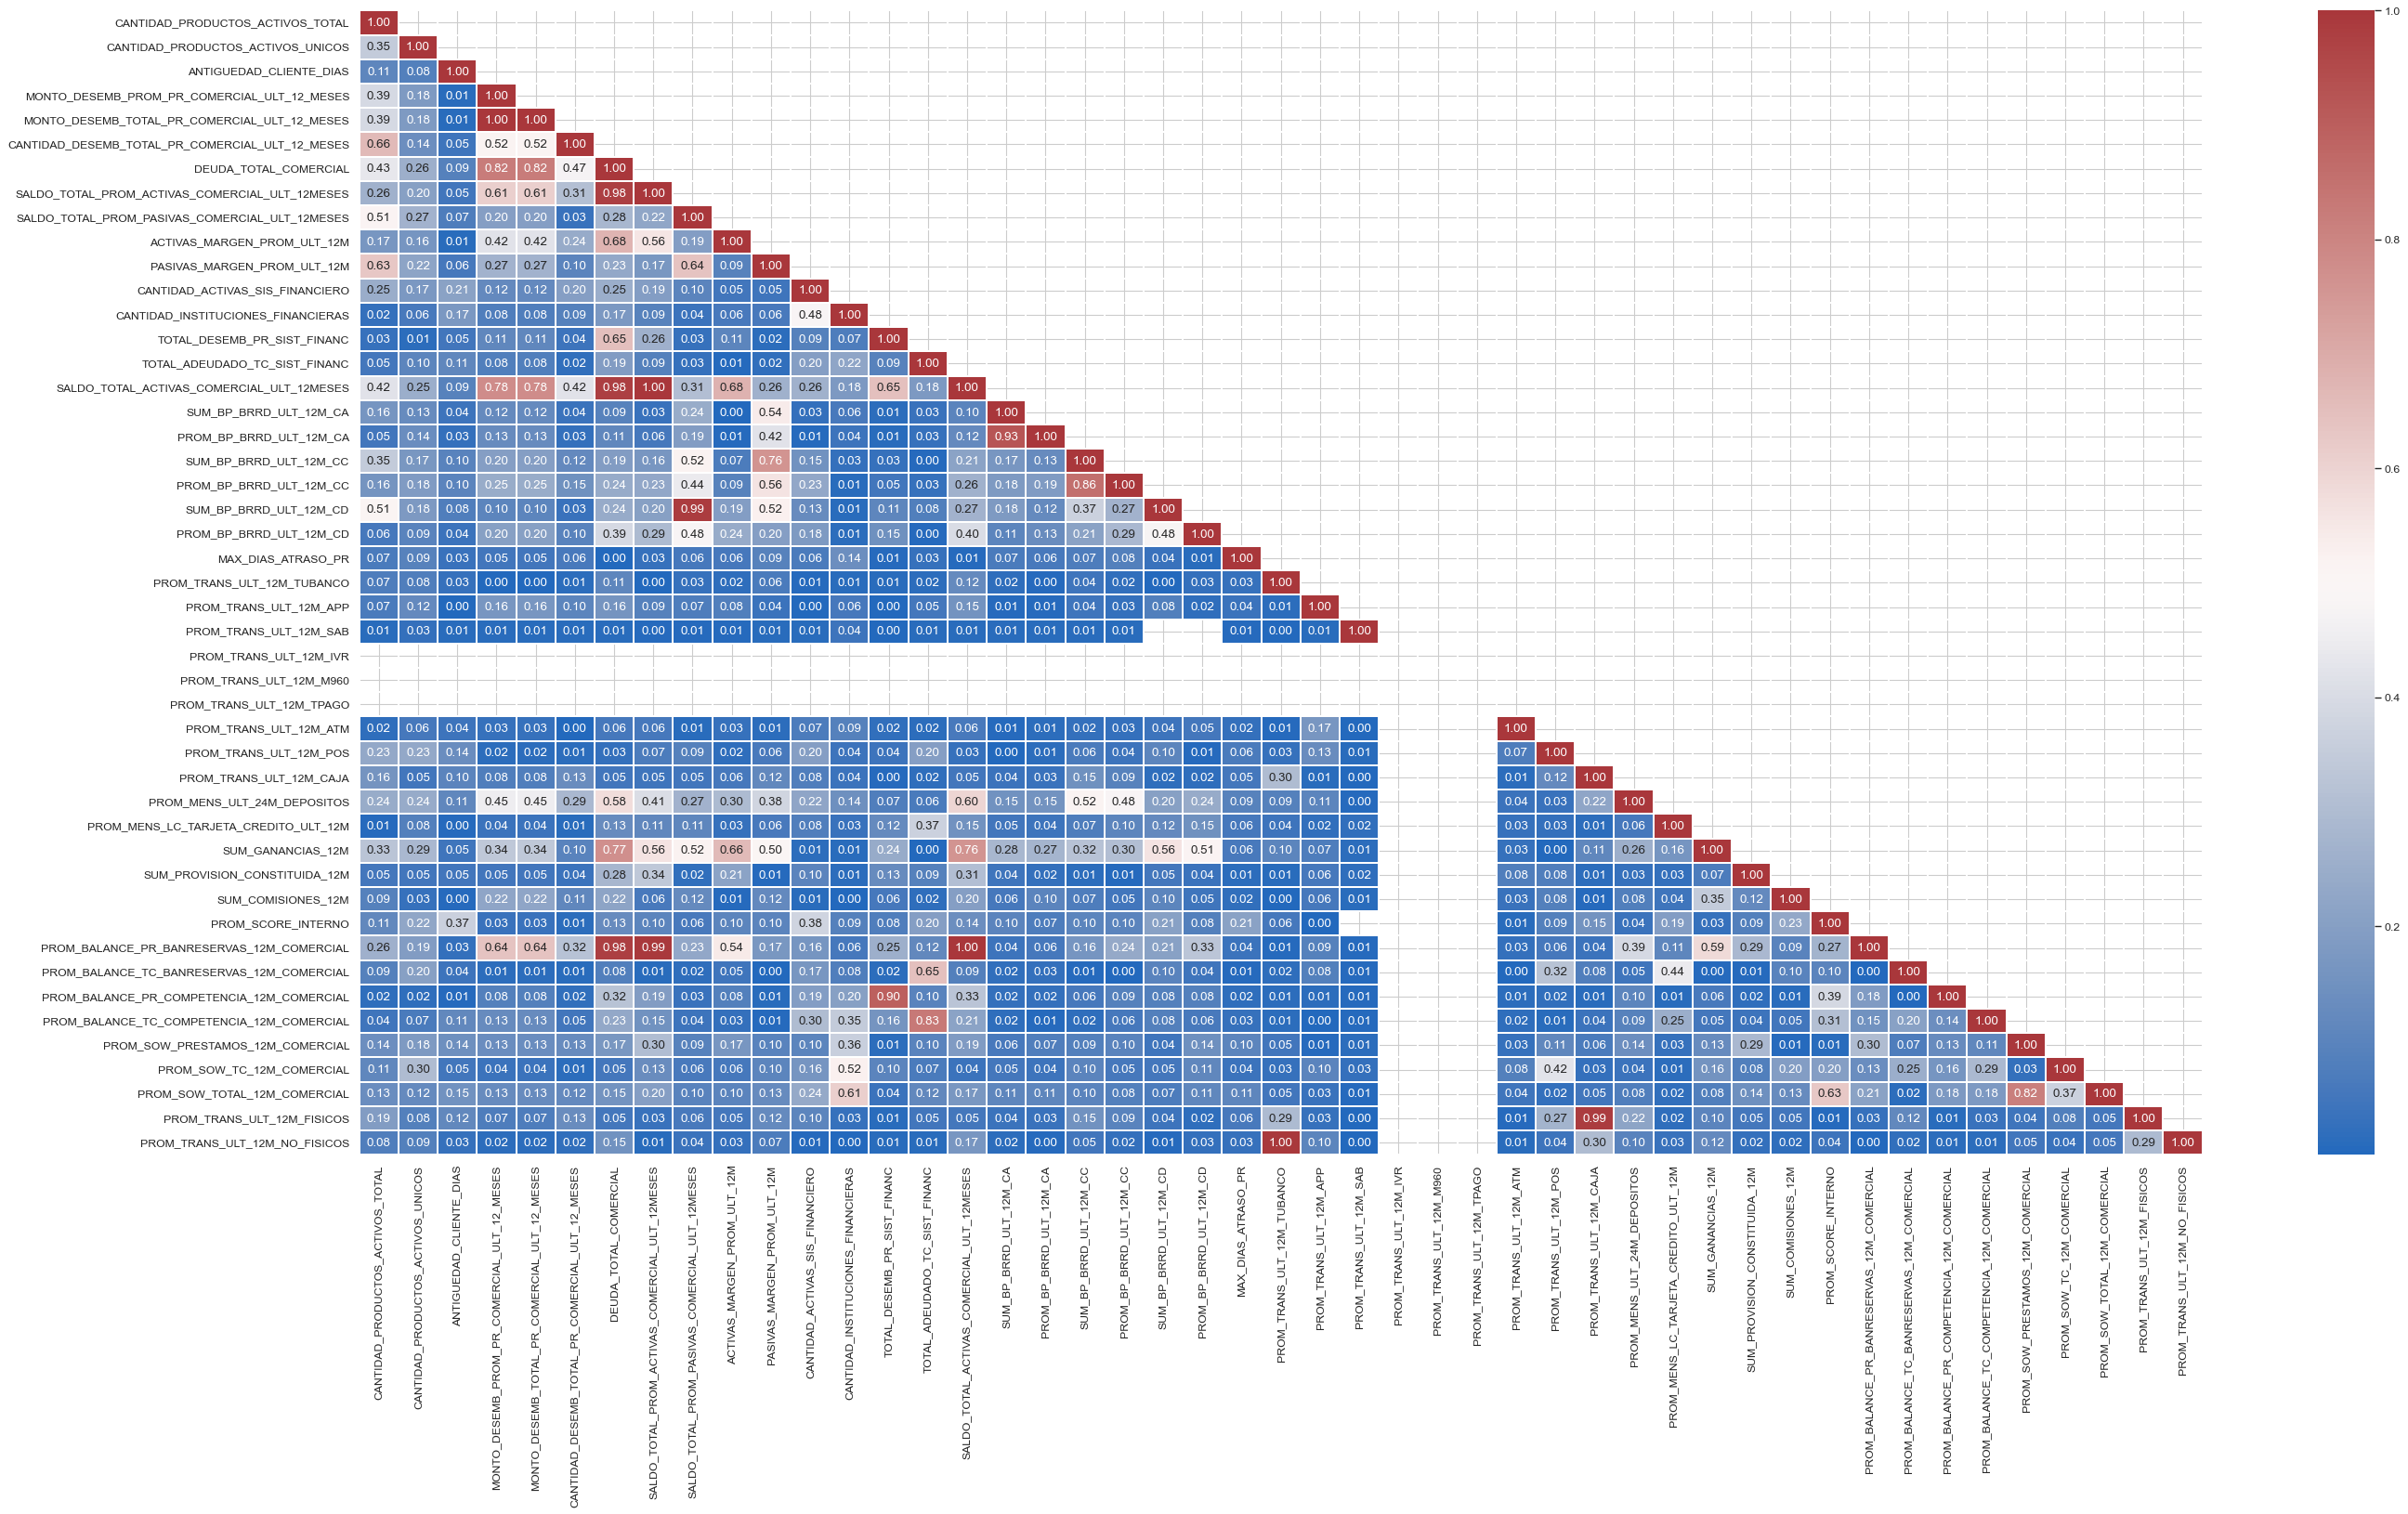

In [62]:
print(f"Nro variables: {df_CN01_01.shape[1] - 1}")
corr = df_CN01_01.drop(columns=['CUSTOMER_SK']).corr(method='pearson').abs()

# Creamos una mascara para ver la correlacion en un solo lado
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True

# Mostramos la matriz de correlacion
plt.figure(figsize=(40,20), dpi = 80)
sns.heatmap(corr, mask = mask, annot=True, cmap='vlag', fmt='.2f', linewidths=0.2)
plt.show()

In [63]:
lista_variables = [
    'CUSTOMER_SK',
    #'INGRESO_RIESGO',
    #'INGRESO_ESTIMADO', 
    'CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL', 
    #'CANTIDAD_PRODUCTOS_ACTIVOS_UNICOS', 
    #'ANTIGUEDAD_CLIENTE_DIAS', 
    'MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES', 
    #'CANTIDAD_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES', 
    #'DEUDA_TOTAL_COMERCIAL', 
    #'SALDO_TOTAL_PROM_ACTIVAS_COMERCIAL_ULT_12MESES', 
    'SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES', 
    'ACTIVAS_MARGEN_PROM_ULT_12M', 
    #'PASIVAS_MARGEN_PROM_ULT_12M', 
    #'CANTIDAD_ACTIVAS_SIS_FINANCIERO', 
    'CANTIDAD_INSTITUCIONES_FINANCIERAS', 
    #'TOTAL_DESEMB_PR_SIST_FINANC', 
    #'TOTAL_ADEUDADO_TC_SIST_FINANC', 
    #'SALDO_TOTAL_ACTIVAS_COMERCIAL_ULT_12MESES', 
    #'SUM_BP_BRRD_ULT_12M_CA', 
    #'PROM_BP_BRRD_ULT_12M_CA', 
    #'SUM_BP_BRRD_ULT_12M_CC', 
    #'PROM_BP_BRRD_ULT_12M_CC', 
    #'SUM_BP_BRRD_ULT_12M_CD', 
    #'PROM_BP_BRRD_ULT_12M_CD', 
    #'MAX_DIAS_ATRASO_PR', 
    #'PROM_TRANS_ULT_12M_TUBANCO', 
    #'PROM_TRANS_ULT_12M_APP', 
    #'PROM_TRANS_ULT_12M_SAB', 
    #'PROM_TRANS_ULT_12M_IVR', 
    #'PROM_TRANS_ULT_12M_M960', 
    #'PROM_TRANS_ULT_12M_TPAGO', 
    #'PROM_TRANS_ULT_12M_ATM', 
    #'PROM_TRANS_ULT_12M_POS', 
    #'PROM_TRANS_ULT_12M_CAJA', 
    'PROM_MENS_ULT_24M_DEPOSITOS', 
    #'PROM_MENS_LC_TARJETA_CREDITO_ULT_12M',
    #'SUM_GANANCIAS_12M', 
    #'SUM_PROVISION_CONSTITUIDA_12M', 
    #'SUM_COMISIONES_12M', 
    #'PROM_SCORE_INTERNO', 
    #'PROM_BALANCE_PR_BANRESERVAS_12M_COMERCIAL', 
    #'PROM_BALANCE_TC_BANRESERVAS_12M_COMERCIAL', 
    'PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL', 
    #'PROM_BALANCE_TC_COMPETENCIA_12M_COMERCIAL',
    'PROM_SOW_PRESTAMOS_12M_COMERCIAL', 
    'PROM_TRANS_ULT_12M_FISICOS', 
    'PROM_TRANS_ULT_12M_NO_FISICOS'
]

In [64]:
df_CN01_01[lista_variables]

,CUSTOMER_SK,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,ACTIVAS_MARGEN_PROM_ULT_12M,CANTIDAD_INSTITUCIONES_FINANCIERAS,PROM_MENS_ULT_24M_DEPOSITOS,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,PROM_SOW_PRESTAMOS_12M_COMERCIAL,PROM_TRANS_ULT_12M_FISICOS,PROM_TRANS_ULT_12M_NO_FISICOS
1,2851211,1,NaN,0.00,"7,133.48",2.00,NaN,NaN,22.49,9.50,0.00
4,548918,2,NaN,0.00,711.38,2.00,"332,107.12",NaN,13.73,41.08,9.75
6,480465,3,NaN,22.44,"-5,934.02",6.00,"48,887.12",NaN,20.10,103.58,0.08
8,186465,7,NaN,"10,220,109.66","2,373.75",3.00,"1,275,587.76",NaN,53.55,28.59,34.08
9,1540579,7,NaN,"2,656,071.49",38.80,3.00,"2,071,641.57",NaN,14.95,2.42,0.00
...,...,...,...,...,...,...,...,...,...,...,...
4370,4223322,2,0.00,0.00,"1,654.38",2.00,"27,979.10","6,124,468.66",8.18,0.33,0.00
4372,4388996,2,0.00,"5,254,532.91","4,562.77",2.00,"9,444,339.13","193,053.23",92.31,2.58,0.00
4373,5159218,1,0.00,"411,912.94",201.17,3.00,"539,836.02","667,923.25",58.33,2.58,3.42
4376,4676307,9,0.00,"708,632.71","41,351.73",8.00,"2,027,274.75","6,225,767.46",74.35,18.50,23.08


Nro variables: 10


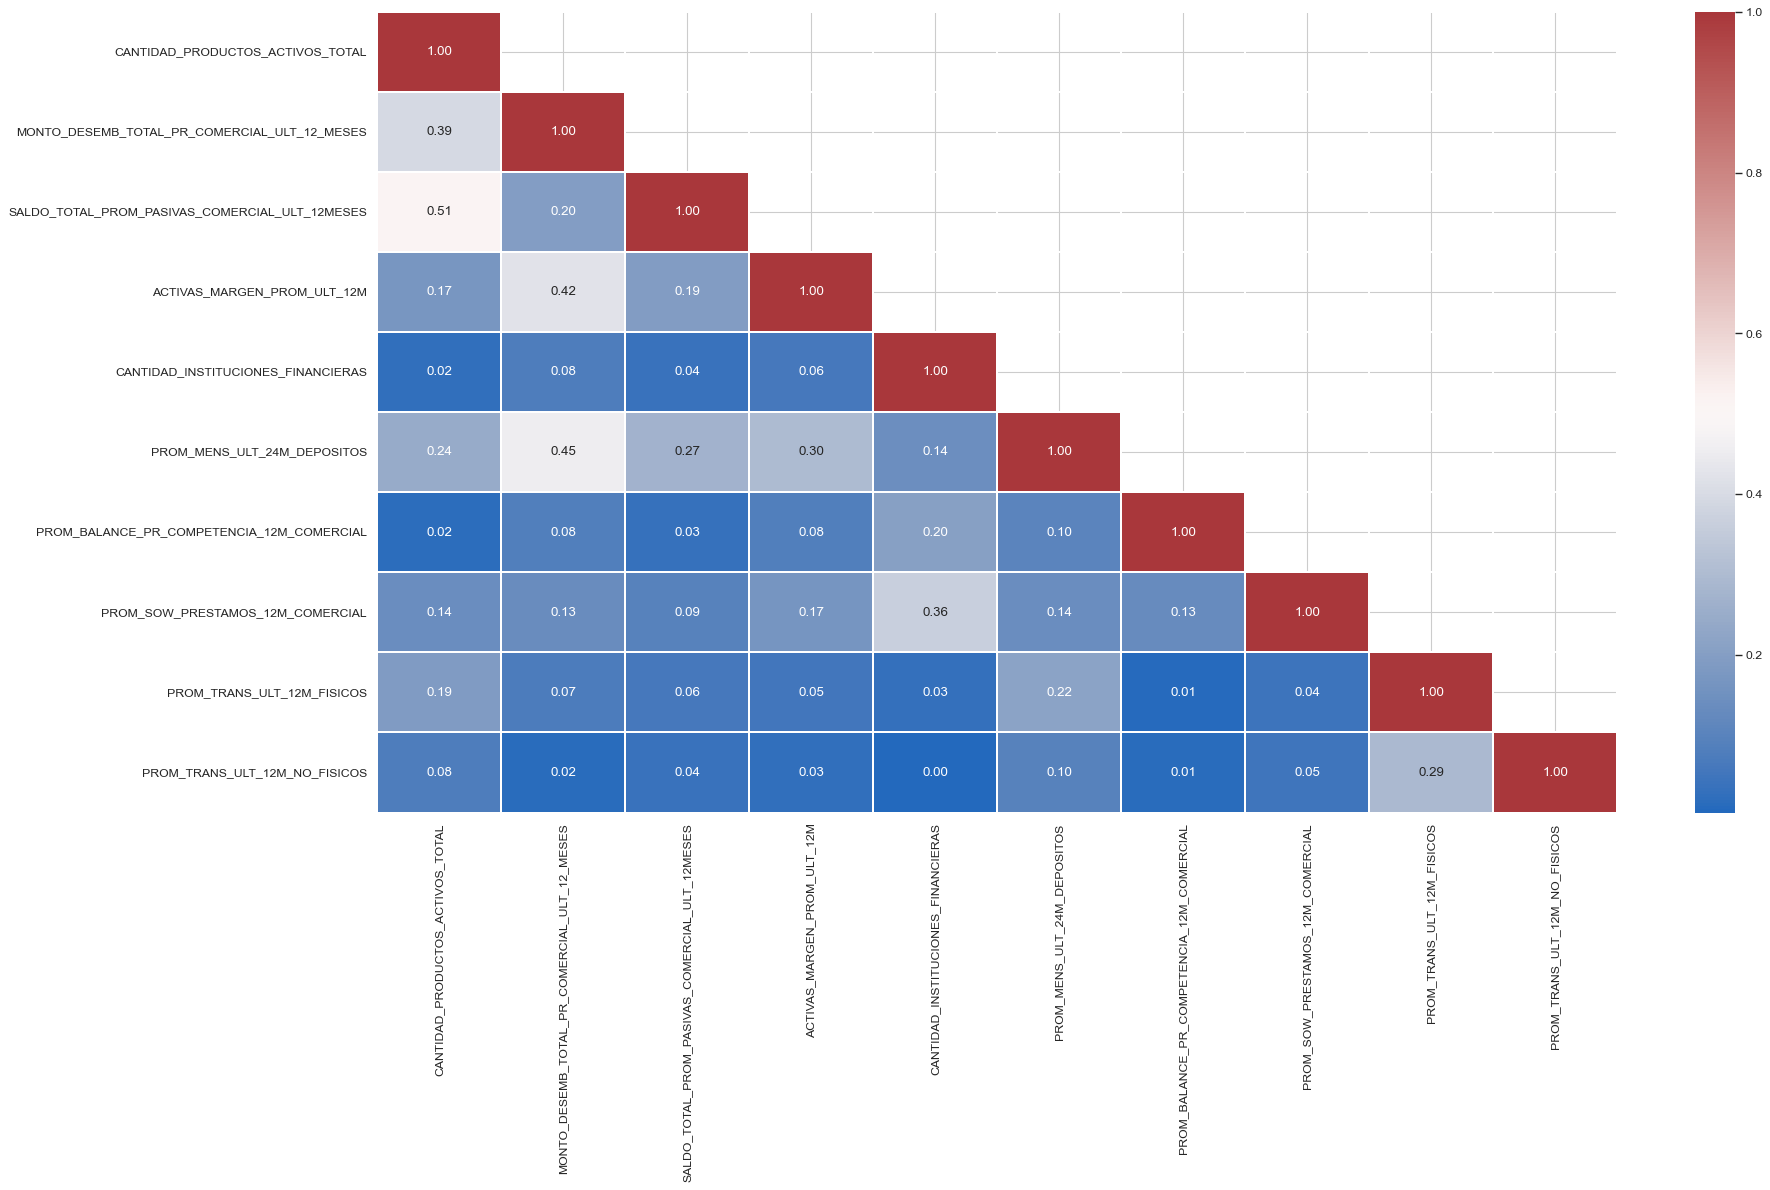

In [65]:
df_correlacion = df_CN01_01[lista_variables]
print(f"Nro variables: {df_correlacion.shape[1] - 1}")
corr = df_correlacion.drop(columns=['CUSTOMER_SK']).corr(method='pearson').abs()

# Creamos una mascara para ver la correlacion en un solo lado
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True

# Mostramos la matriz de correlacion
plt.figure(figsize=(25,13), dpi = 80)
sns.heatmap(corr, mask = mask, annot=True, cmap='vlag', fmt='.2f', linewidths=0.2)
plt.show()

In [66]:
df_CN01_02 = df_CN01_01[lista_variables]

# Resumen Data
print(f'Nro Clientes: {df_CN01_02["CUSTOMER_SK"].nunique():,}')
print(f'Nro Columnas: {df_CN01_02.shape[1]:,}')
print(f'Nro Filas: {df_CN01_02.shape[0]:,}')
df_CN01_02.head(3)

Nro Clientes: 1,528
Nro Columnas: 11
Nro Filas: 1,528


,CUSTOMER_SK,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,ACTIVAS_MARGEN_PROM_ULT_12M,CANTIDAD_INSTITUCIONES_FINANCIERAS,PROM_MENS_ULT_24M_DEPOSITOS,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,PROM_SOW_PRESTAMOS_12M_COMERCIAL,PROM_TRANS_ULT_12M_FISICOS,PROM_TRANS_ULT_12M_NO_FISICOS
1,2851211,1,NaN,0.00,"7,133.48",2.00,NaN,NaN,22.49,9.50,0.00
4,548918,2,NaN,0.00,711.38,2.00,"332,107.12",NaN,13.73,41.08,9.75
6,480465,3,NaN,22.44,"-5,934.02",6.00,"48,887.12",NaN,20.10,103.58,0.08


In [67]:
revision_missings(df_CN01_02)

,COLUMNA,NRO_NULL,%_NULL
0,CUSTOMER_SK,0,0.0%
1,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,0,0.0%
2,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,440,28.8%
3,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,0,0.0%
4,ACTIVAS_MARGEN_PROM_ULT_12M,0,0.0%
5,CANTIDAD_INSTITUCIONES_FINANCIERAS,8,0.52%
6,PROM_MENS_ULT_24M_DEPOSITOS,23,1.51%
7,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,234,15.31%
8,PROM_SOW_PRESTAMOS_12M_COMERCIAL,0,0.0%
9,PROM_TRANS_ULT_12M_FISICOS,0,0.0%


In [68]:
df_CN01_02 = df_CN01_02.fillna(0)

# Resumen Data
print(f'Nro Clientes: {df_CN01_02["CUSTOMER_SK"].nunique():,}')
print(f'Nro Columnas: {df_CN01_02.shape[1]:,}')
print(f'Nro Filas: {df_CN01_02.shape[0]:,}')
df_CN01_02.head(3)

Nro Clientes: 1,528
Nro Columnas: 11
Nro Filas: 1,528


,CUSTOMER_SK,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,ACTIVAS_MARGEN_PROM_ULT_12M,CANTIDAD_INSTITUCIONES_FINANCIERAS,PROM_MENS_ULT_24M_DEPOSITOS,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,PROM_SOW_PRESTAMOS_12M_COMERCIAL,PROM_TRANS_ULT_12M_FISICOS,PROM_TRANS_ULT_12M_NO_FISICOS
1,2851211,1,0.00,0.00,"7,133.48",2.00,0.00,0.00,22.49,9.50,0.00
4,548918,2,0.00,0.00,711.38,2.00,"332,107.12",0.00,13.73,41.08,9.75
6,480465,3,0.00,22.44,"-5,934.02",6.00,"48,887.12",0.00,20.10,103.58,0.08


In [69]:
# Describe General
df_CN01_02.drop(columns=['CUSTOMER_SK']).quantile([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99, 1]).transpose()

,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.95,0.99,1.00
CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,1.00,2.00,3.00,3.00,4.00,4.00,5.00,6.00,8.00,11.00,15.00,30.00,233.00
MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"11,300,000.00","50,000,000.00","123,950,000.00","454,985,361.21","1,526,986,740.11"
SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,"-7,486,421.47",35.17,"90,012.68","315,403.01","711,317.05","1,415,770.07","2,808,590.21","5,959,528.16","13,754,529.87","40,638,620.43","87,966,295.04","346,848,349.49","1,297,295,177.67"
ACTIVAS_MARGEN_PROM_ULT_12M,"-882,375.69","-4,235.18",-769.20,-25.75,"1,269.82","4,798.63","11,516.42","23,200.09","46,537.19","125,566.20","259,769.47","633,198.24","2,653,070.30"
CANTIDAD_INSTITUCIONES_FINANCIERAS,0.00,2.00,2.00,3.00,4.00,4.00,5.00,6.00,7.00,9.00,10.00,13.00,18.00
PROM_MENS_ULT_24M_DEPOSITOS,0.00,"236,798.34","923,574.68","1,877,210.86","3,420,112.11","5,275,171.76","8,619,713.96","13,988,462.03","23,423,352.05","42,061,301.36","74,322,167.89","179,887,848.45","608,873,490.55"
PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,0.00,0.00,0.00,"163,165.65","1,601,780.59","4,881,163.88","10,270,937.26","17,049,228.12","33,046,907.28","79,868,420.94","157,808,678.19","499,998,192.76","4,372,340,990.77"
PROM_SOW_PRESTAMOS_12M_COMERCIAL,0.00,0.50,8.04,18.05,29.14,41.84,56.35,74.34,90.91,92.31,92.31,100.00,100.00
PROM_TRANS_ULT_12M_FISICOS,0.00,0.25,1.95,5.58,10.42,17.84,27.94,41.96,69.62,123.30,186.57,539.60,"5,404.92"
PROM_TRANS_ULT_12M_NO_FISICOS,0.00,0.00,0.08,1.75,4.34,8.16,13.69,22.74,35.38,66.63,104.11,205.68,"5,314.66"


#### 03.2. Limpieza de Outliers

In [70]:
# Describe General
df_CN01_02.drop(columns=['CUSTOMER_SK']).quantile([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]).transpose()

,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,1.00,2.00,3.00,3.00,4.00,4.00,5.00,6.00,8.00,11.00,233.00
MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"11,300,000.00","50,000,000.00","1,526,986,740.11"
SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,"-7,486,421.47",35.17,"90,012.68","315,403.01","711,317.05","1,415,770.07","2,808,590.21","5,959,528.16","13,754,529.87","40,638,620.43","1,297,295,177.67"
ACTIVAS_MARGEN_PROM_ULT_12M,"-882,375.69","-4,235.18",-769.20,-25.75,"1,269.82","4,798.63","11,516.42","23,200.09","46,537.19","125,566.20","2,653,070.30"
CANTIDAD_INSTITUCIONES_FINANCIERAS,0.00,2.00,2.00,3.00,4.00,4.00,5.00,6.00,7.00,9.00,18.00
PROM_MENS_ULT_24M_DEPOSITOS,0.00,"236,798.34","923,574.68","1,877,210.86","3,420,112.11","5,275,171.76","8,619,713.96","13,988,462.03","23,423,352.05","42,061,301.36","608,873,490.55"
PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,0.00,0.00,0.00,"163,165.65","1,601,780.59","4,881,163.88","10,270,937.26","17,049,228.12","33,046,907.28","79,868,420.94","4,372,340,990.77"
PROM_SOW_PRESTAMOS_12M_COMERCIAL,0.00,0.50,8.04,18.05,29.14,41.84,56.35,74.34,90.91,92.31,100.00
PROM_TRANS_ULT_12M_FISICOS,0.00,0.25,1.95,5.58,10.42,17.84,27.94,41.96,69.62,123.30,"5,404.92"
PROM_TRANS_ULT_12M_NO_FISICOS,0.00,0.00,0.08,1.75,4.34,8.16,13.69,22.74,35.38,66.63,"5,314.66"


In [71]:
# Solo Limite Inferior
df_CN01_02.drop(columns=['CUSTOMER_SK']).quantile([.0, .01, .02, .03, .04, .05, .06, .07, .08, .09, .1]).transpose()

,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10
CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,1.00,1.00,1.00,1.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,"-7,486,421.47",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,35.17
ACTIVAS_MARGEN_PROM_ULT_12M,"-882,375.69","-238,574.42","-125,990.26","-51,889.32","-29,705.64","-18,536.89","-12,953.35","-8,630.99","-6,663.36","-5,099.24","-4,235.18"
CANTIDAD_INSTITUCIONES_FINANCIERAS,0.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,2.00,2.00,2.00
PROM_MENS_ULT_24M_DEPOSITOS,0.00,0.00,9.71,"5,502.95","28,833.75","55,673.85","80,875.75","104,192.66","142,142.50","190,217.82","236,798.34"
PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PROM_SOW_PRESTAMOS_12M_COMERCIAL,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50
PROM_TRANS_ULT_12M_FISICOS,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.08,0.17,0.20,0.25
PROM_TRANS_ULT_12M_NO_FISICOS,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [72]:
# Solo Limite Superior
df_CN01_02.drop(columns=['CUSTOMER_SK']).quantile([.9, .91, .92, .93, .94, .95, .96, .97, .98, .99, 1]).transpose()

,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00
CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,11.00,11.00,12.00,13.00,14.00,15.00,17.00,19.00,22.00,30.00,233.00
MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,"50,000,000.00","55,000,000.00","65,294,840.00","79,506,050.00","96,900,000.00","123,950,000.00","153,305,533.52","188,334,054.37","226,771,968.86","454,985,361.21","1,526,986,740.11"
SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,"40,638,620.43","48,310,020.04","54,786,880.39","62,555,301.05","78,446,963.43","87,966,295.04","113,621,678.70","156,825,960.47","243,164,498.64","346,848,349.49","1,297,295,177.67"
ACTIVAS_MARGEN_PROM_ULT_12M,"125,566.20","141,275.15","156,185.14","189,259.16","219,940.22","259,769.47","306,020.22","349,409.28","458,757.29","633,198.24","2,653,070.30"
CANTIDAD_INSTITUCIONES_FINANCIERAS,9.00,9.00,9.00,9.00,10.00,10.00,10.00,11.00,11.00,13.00,18.00
PROM_MENS_ULT_24M_DEPOSITOS,"42,061,301.36","46,884,755.09","51,652,570.42","57,712,120.98","64,415,026.68","74,322,167.89","85,296,333.32","98,930,160.09","126,324,413.93","179,887,848.45","608,873,490.55"
PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,"79,868,420.94","89,614,717.21","102,352,959.97","116,799,307.43","141,133,850.27","157,808,678.19","208,670,277.71","269,082,036.42","339,968,514.06","499,998,192.76","4,372,340,990.77"
PROM_SOW_PRESTAMOS_12M_COMERCIAL,92.31,92.31,92.31,92.31,92.31,92.31,92.31,100.00,100.00,100.00,100.00
PROM_TRANS_ULT_12M_FISICOS,123.30,132.75,146.08,160.56,171.58,186.57,211.97,291.95,395.40,539.60,"5,404.92"
PROM_TRANS_ULT_12M_NO_FISICOS,66.63,72.06,77.28,83.19,92.05,104.11,114.48,127.83,165.54,205.68,"5,314.66"


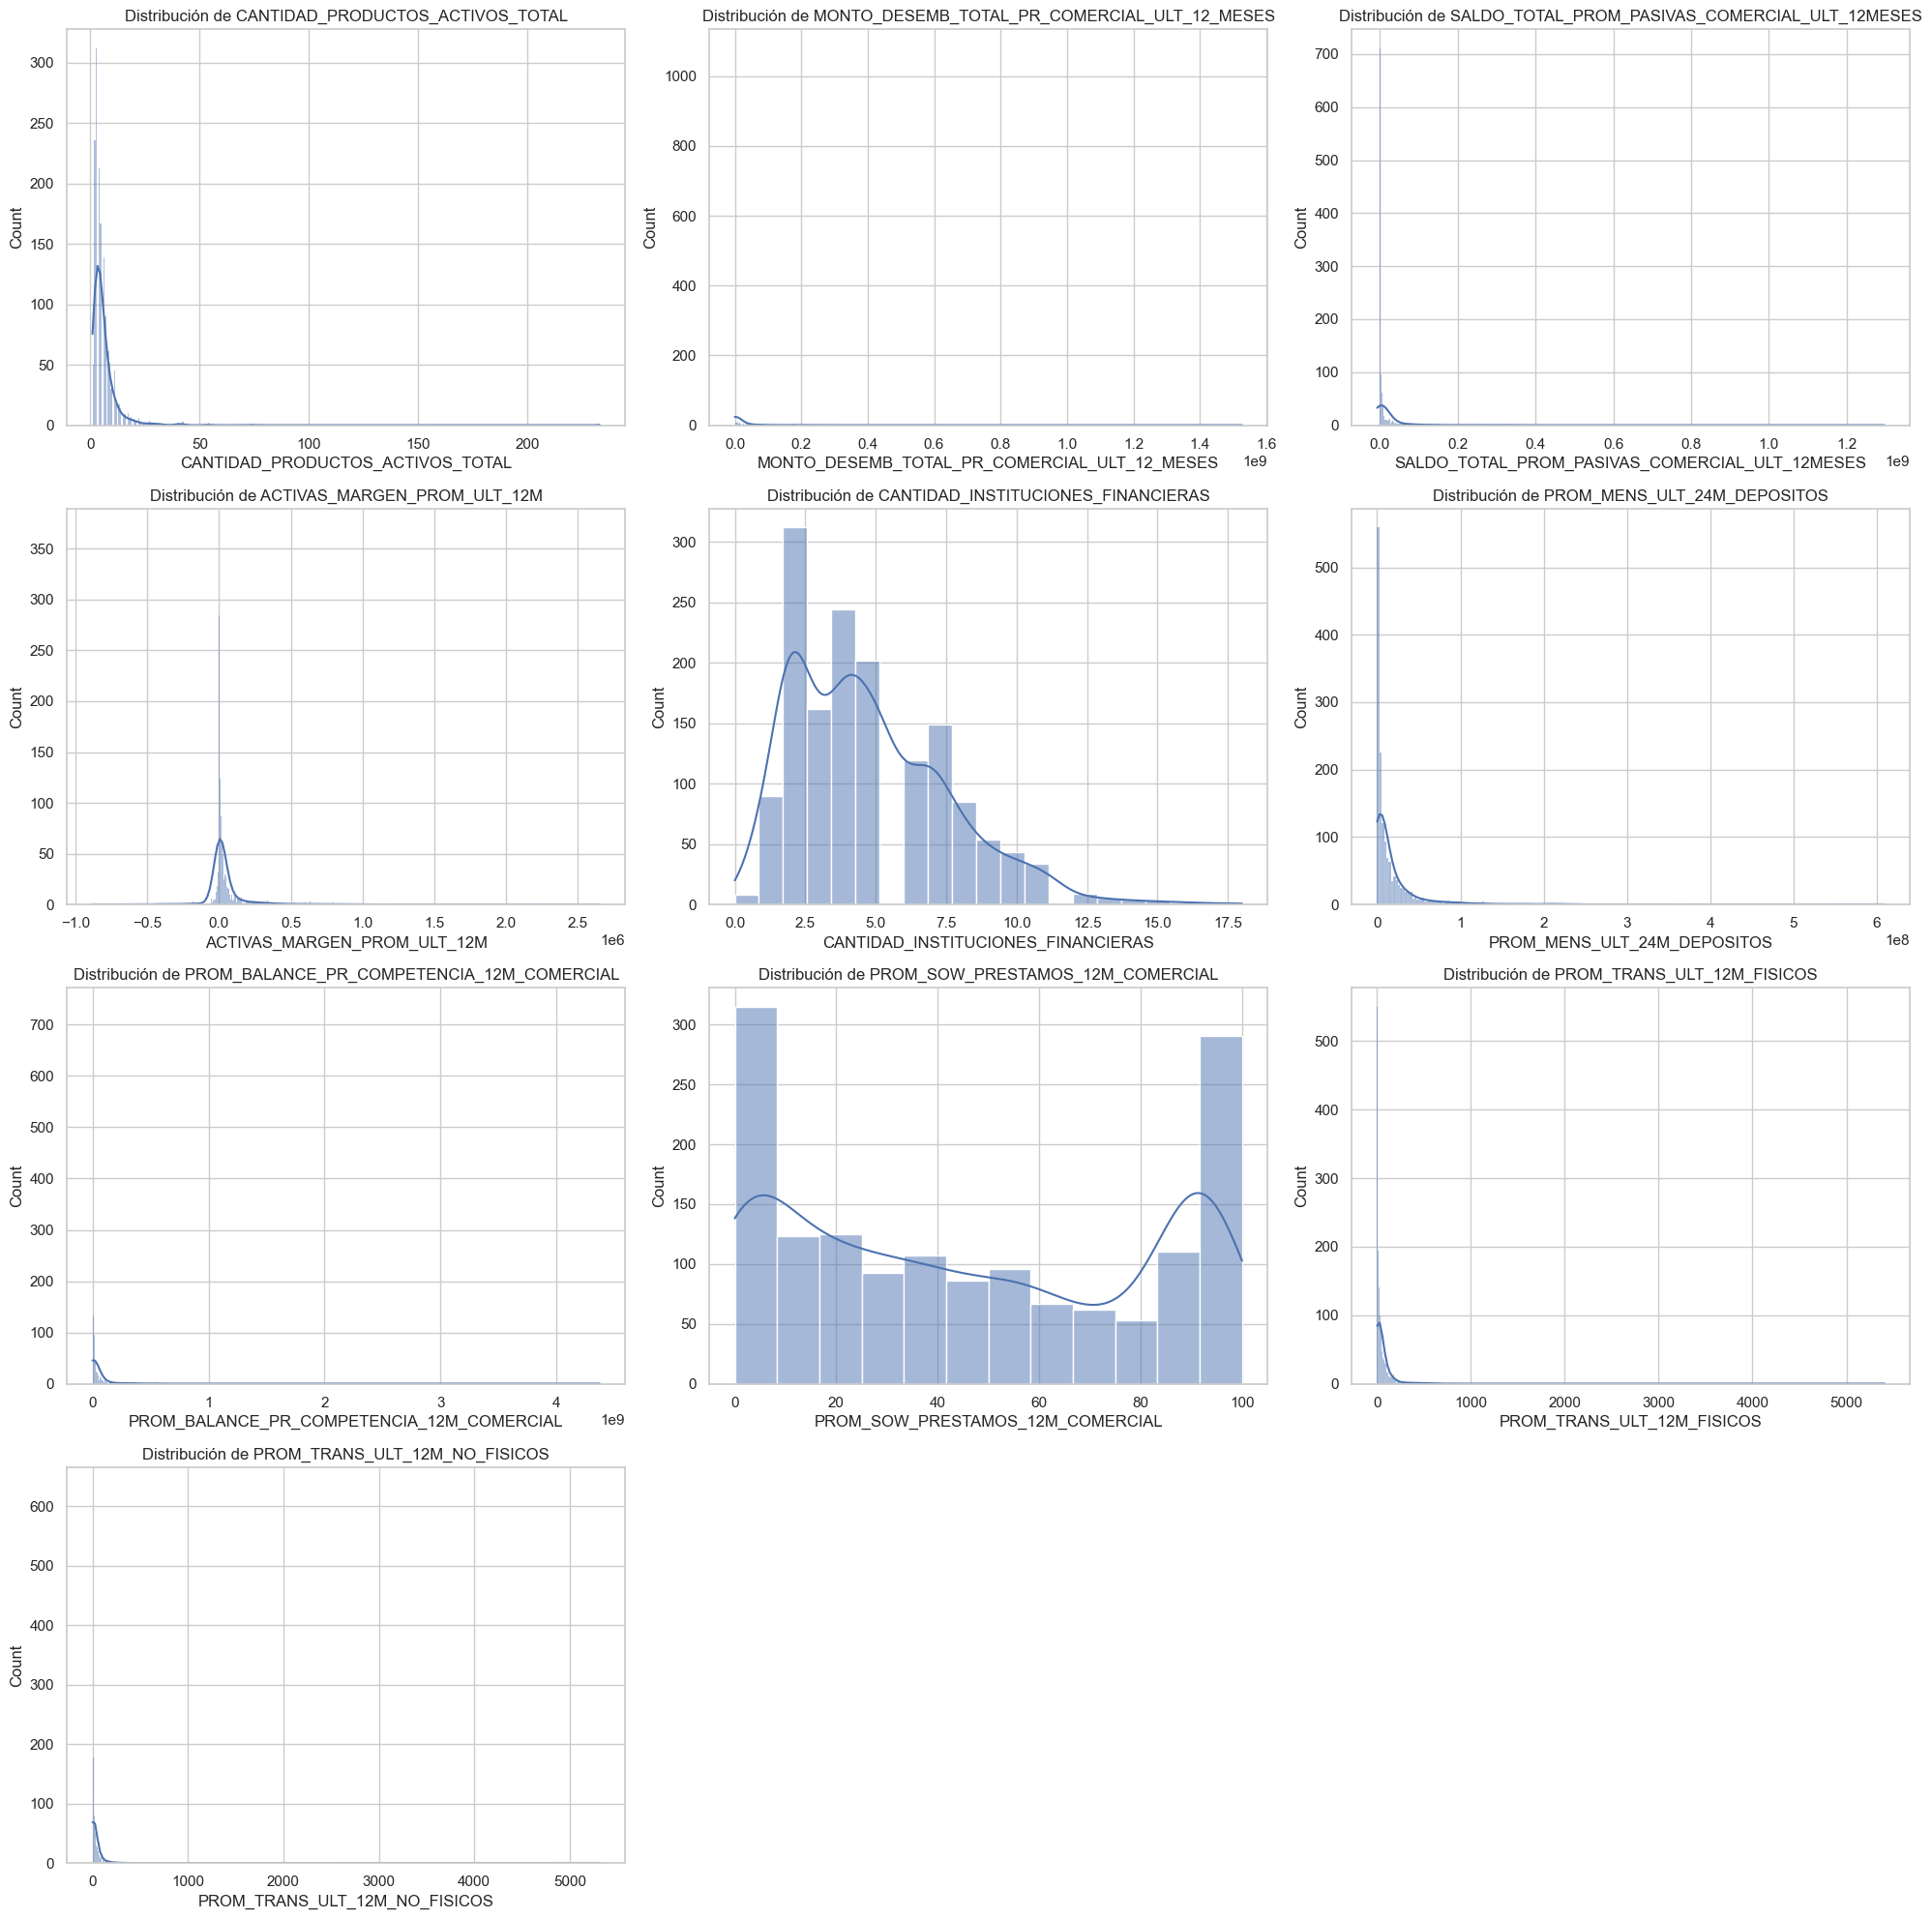

In [75]:
# Antes de limpiar
visualizar_kde(df_CN01_02, excluir_columnas=['CUSTOMER_SK'], num_columnas=3, figsize=(20, 5))

In [76]:
limitar_por_derecha(df_CN01_02, 'CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL', 0.99)

limitar_por_derecha(df_CN01_02, 'MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES', 0.99)

df_CN01_02['SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES'][df_CN01_02['SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES'] < 0] = 0
limitar_por_derecha(df_CN01_02, 'SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES', 0.99)

limitar_por_izquierda(df_CN01_02, 'ACTIVAS_MARGEN_PROM_ULT_12M', 0.03)
limitar_por_derecha(df_CN01_02, 'ACTIVAS_MARGEN_PROM_ULT_12M', 0.99)

#limitar_por_derecha(df_CN01_02, 'PASIVAS_MARGEN_PROM_ULT_12M', 0.99)
#limitar_por_derecha(df_CN01_02, 'CANTIDAD_INSTITUCIONES_FINANCIERAS', 0.99)
#limitar_por_derecha(df_CN01_02, 'TOTAL_DESEMB_PR_SIST_FINANC', 0.99)

#limitar_por_derecha(df_CN01_02, 'MAX_DIAS_ATRASO_PR', 0.99)

limitar_por_derecha(df_CN01_02, 'PROM_MENS_ULT_24M_DEPOSITOS', 0.99)
limitar_por_derecha(df_CN01_02, 'PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL', 0.99)
#limitar_por_izquierda(df_CN01_02, 'SALDO_TOTAL_PROM_ACTIVAS_COMERCIAL_ULT_12MESES', 0.01)
#limitar_por_derecha(df_CN01_02, 'SALDO_TOTAL_PROM_ACTIVAS_COMERCIAL_ULT_12MESES', 0.99)

#limitar_por_derecha(df_CN01_02, 'SUM_BP_BRRD_ULT_12M_CA', 0.98)
#limitar_por_derecha(df_CN01_02, 'SUM_BP_BRRD_ULT_12M_CC', 0.99)
#limitar_por_derecha(df_CN01_02, 'SUM_BP_BRRD_ULT_12M_CD', 0.98)

limitar_por_derecha(df_CN01_02, 'PROM_TRANS_ULT_12M_FISICOS', 0.98)
limitar_por_derecha(df_CN01_02, 'PROM_TRANS_ULT_12M_NO_FISICOS', 0.98)

,CUSTOMER_SK,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,ACTIVAS_MARGEN_PROM_ULT_12M,CANTIDAD_INSTITUCIONES_FINANCIERAS,PROM_MENS_ULT_24M_DEPOSITOS,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,PROM_SOW_PRESTAMOS_12M_COMERCIAL,PROM_TRANS_ULT_12M_FISICOS,PROM_TRANS_ULT_12M_NO_FISICOS
1,2851211,1,0.00,0.00,"7,133.48",2.00,0.00,0.00,22.49,9.50,0.00
4,548918,2,0.00,0.00,711.38,2.00,"332,107.12",0.00,13.73,41.08,9.75
6,480465,3,0.00,22.44,"-5,934.02",6.00,"48,887.12",0.00,20.10,103.58,0.08
8,186465,7,0.00,"10,220,109.66","2,373.75",3.00,"1,275,587.76",0.00,53.55,28.59,34.08
9,1540579,7,0.00,"2,656,071.49",38.80,3.00,"2,071,641.57",0.00,14.95,2.42,0.00
...,...,...,...,...,...,...,...,...,...,...,...
4370,4223322,2,0.00,0.00,"1,654.38",2.00,"27,979.10","6,124,468.66",8.18,0.33,0.00
4372,4388996,2,0.00,"5,254,532.91","4,562.77",2.00,"9,444,339.13","193,053.23",92.31,2.58,0.00
4373,5159218,1,0.00,"411,912.94",201.17,3.00,"539,836.02","667,923.25",58.33,2.58,3.42
4376,4676307,9,0.00,"708,632.71","41,351.73",8.00,"2,027,274.75","6,225,767.46",74.35,18.50,23.08


In [77]:
# Describe General
df_CN01_02.drop(columns=['CUSTOMER_SK']).quantile([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]).transpose()

,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,1.00,2.00,3.00,3.00,4.00,4.00,5.00,6.00,8.00,11.00,30.00
MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"11,300,000.00","50,000,000.00","454,985,361.21"
SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,0.00,35.17,"90,012.68","315,403.01","711,317.05","1,415,770.07","2,808,590.21","5,959,528.16","13,754,529.87","40,638,620.43","346,848,349.49"
ACTIVAS_MARGEN_PROM_ULT_12M,"-51,889.32","-4,235.18",-769.20,-25.75,"1,269.82","4,798.63","11,516.42","23,200.09","46,537.19","125,566.20","633,198.24"
CANTIDAD_INSTITUCIONES_FINANCIERAS,0.00,2.00,2.00,3.00,4.00,4.00,5.00,6.00,7.00,9.00,18.00
PROM_MENS_ULT_24M_DEPOSITOS,0.00,"236,798.34","923,574.68","1,877,210.86","3,420,112.11","5,275,171.76","8,619,713.96","13,988,462.03","23,423,352.05","42,061,301.36","179,887,848.45"
PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,0.00,0.00,0.00,"163,165.65","1,601,780.59","4,881,163.88","10,270,937.26","17,049,228.12","33,046,907.28","79,868,420.94","499,998,192.76"
PROM_SOW_PRESTAMOS_12M_COMERCIAL,0.00,0.50,8.04,18.05,29.14,41.84,56.35,74.34,90.91,92.31,100.00
PROM_TRANS_ULT_12M_FISICOS,0.00,0.25,1.95,5.58,10.42,17.84,27.94,41.96,69.62,123.30,395.40
PROM_TRANS_ULT_12M_NO_FISICOS,0.00,0.00,0.08,1.75,4.34,8.16,13.69,22.74,35.38,66.63,165.54


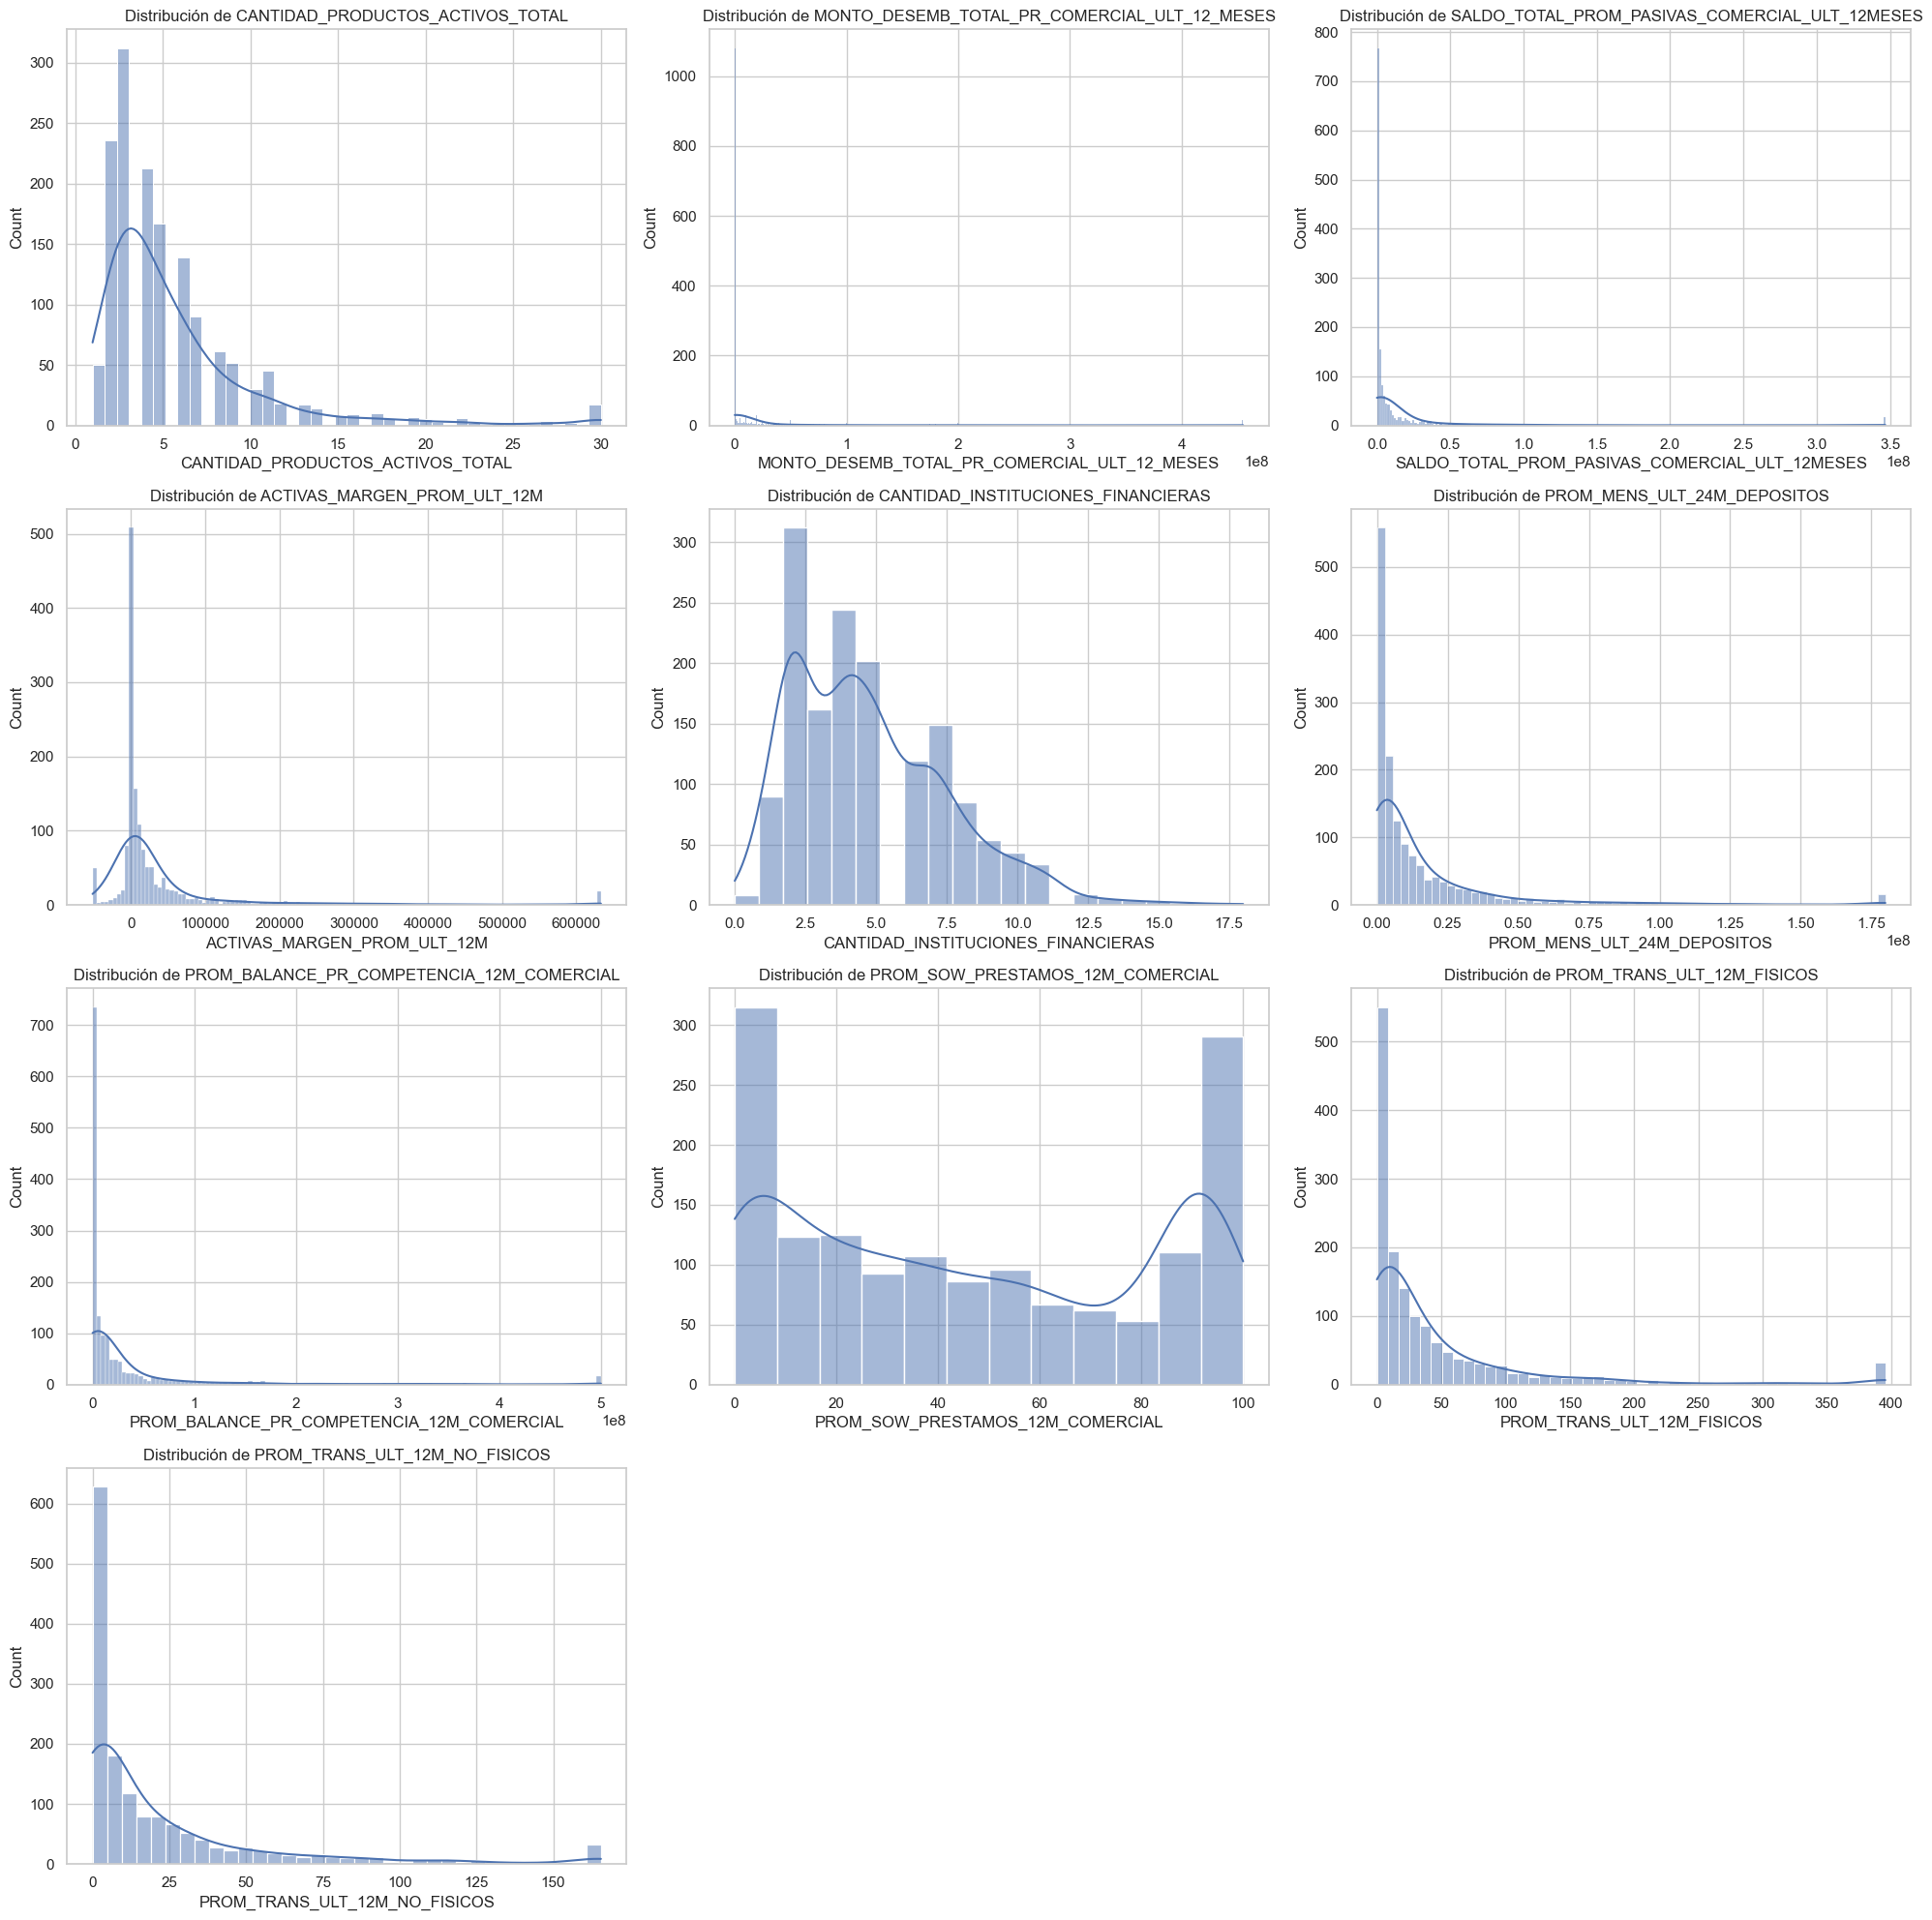

In [79]:
visualizar_kde(df_CN01_02, excluir_columnas=['CUSTOMER_SK'], num_columnas=3, figsize=(20, 5))

#### 03.3. Modelo de K-Means

In [80]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [81]:
# Resumen Data
print(f'Nro Clientes: {df_CN01_02["CUSTOMER_SK"].nunique():,}')
print(f'Nro Columnas: {df_CN01_02.shape[1]:,}')
print(f'Nro Filas: {df_CN01_02.shape[0]:,}')
df_CN01_02.head(3)

Nro Clientes: 1,528
Nro Columnas: 11
Nro Filas: 1,528


,CUSTOMER_SK,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,ACTIVAS_MARGEN_PROM_ULT_12M,CANTIDAD_INSTITUCIONES_FINANCIERAS,PROM_MENS_ULT_24M_DEPOSITOS,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,PROM_SOW_PRESTAMOS_12M_COMERCIAL,PROM_TRANS_ULT_12M_FISICOS,PROM_TRANS_ULT_12M_NO_FISICOS
1,2851211,1,0.00,0.00,"7,133.48",2.00,0.00,0.00,22.49,9.50,0.00
4,548918,2,0.00,0.00,711.38,2.00,"332,107.12",0.00,13.73,41.08,9.75
6,480465,3,0.00,22.44,"-5,934.02",6.00,"48,887.12",0.00,20.10,103.58,0.08


In [82]:
revision_missings(df_CN01_02)

,COLUMNA,NRO_NULL,%_NULL
0,CUSTOMER_SK,0,0.0%
1,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,0,0.0%
2,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,0,0.0%
3,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,0,0.0%
4,ACTIVAS_MARGEN_PROM_ULT_12M,0,0.0%
5,CANTIDAD_INSTITUCIONES_FINANCIERAS,0,0.0%
6,PROM_MENS_ULT_24M_DEPOSITOS,0,0.0%
7,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,0,0.0%
8,PROM_SOW_PRESTAMOS_12M_COMERCIAL,0,0.0%
9,PROM_TRANS_ULT_12M_FISICOS,0,0.0%


In [83]:
df_ml = df_CN01_02.copy()

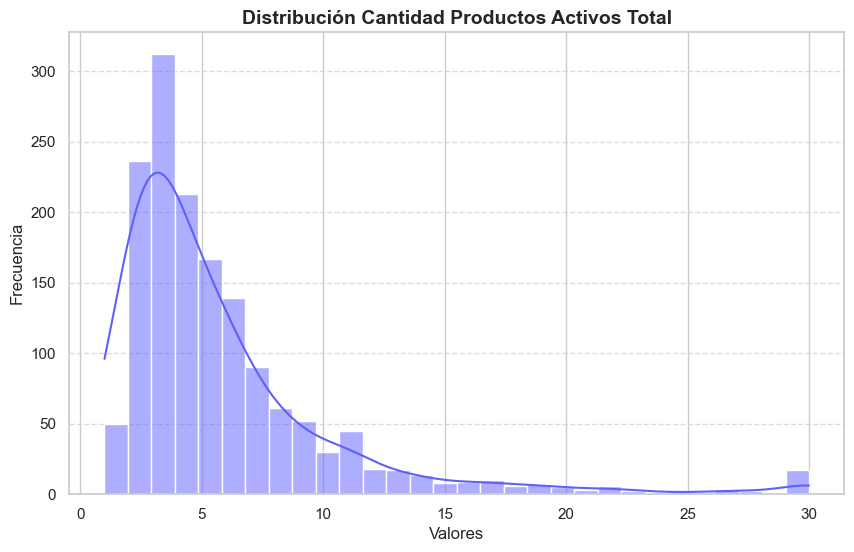

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Establecer los colores más saturados
barra_color = "#5f5fff"  # Más saturado que #7f7fff
linea_color = "#11117e"  # Más saturado que #2525ff

# Crear el histograma con la distribución y KDE
sns.histplot(df_ml['CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL'], bins=30, kde=True, color=barra_color, line_kws={'color': linea_color})

# Personalización
plt.title("Distribución Cantidad Productos Activos Total", fontsize=14, fontweight="bold")
plt.xlabel("Valores", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)  # Cambiar "Densidad" a "Frecuencia"
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()

In [85]:
df_ml_scaled = df_ml.copy()

# Seleccionar las columnas a escalar (todas excepto 'CUSTOMER_SK')
columns_to_scale = df_ml.columns[df_ml.columns != 'CUSTOMER_SK']

# Aplicar RobustScaler
robust_scaler = RobustScaler()
#scaler = StandardScaler()
df_ml_scaled[columns_to_scale] = robust_scaler.fit_transform(df_ml_scaled[columns_to_scale])

# Aplicar MinMaxScaler después de RobustScaler
minmax_scaler = MinMaxScaler()
df_ml_scaled[columns_to_scale] = minmax_scaler.fit_transform(df_ml_scaled[columns_to_scale])

#R esumen Data
print(f'Nro Clientes: {df_ml_scaled["CUSTOMER_SK"].nunique():,}')
print(f'Nro Columnas: {df_ml_scaled.shape[1]:,}')
print(f'Nro Filas: {df_ml_scaled.shape[0]:,}')
df_ml_scaled.head(5)

Nro Clientes: 1,528
Nro Columnas: 11
Nro Filas: 1,528


,CUSTOMER_SK,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,ACTIVAS_MARGEN_PROM_ULT_12M,CANTIDAD_INSTITUCIONES_FINANCIERAS,PROM_MENS_ULT_24M_DEPOSITOS,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,PROM_SOW_PRESTAMOS_12M_COMERCIAL,PROM_TRANS_ULT_12M_FISICOS,PROM_TRANS_ULT_12M_NO_FISICOS
1,2851211,0.00,0.00,0.00,0.09,0.11,0.00,0.00,0.22,0.02,0.00
4,548918,0.03,0.00,0.00,0.08,0.11,0.00,0.00,0.14,0.10,0.06
6,480465,0.07,0.00,0.00,0.07,0.33,0.00,0.00,0.20,0.26,0.00
8,186465,0.21,0.00,0.03,0.08,0.17,0.01,0.00,0.54,0.07,0.21
9,1540579,0.21,0.00,0.01,0.08,0.17,0.01,0.00,0.15,0.01,0.00


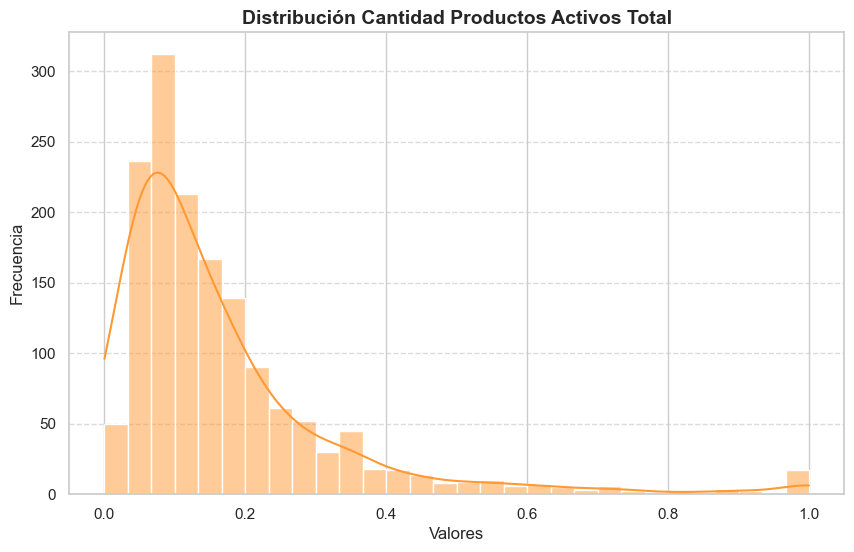

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

# Establecer los colores más saturados
barra_color = "#FF9933"  # Más saturado que #7f7fff
linea_color = "#11117e"  # Más saturado que #2525ff

# Crear el histograma con la distribución y KDE
sns.histplot(df_ml_scaled['CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL'], bins=30, kde=True, color=barra_color, line_kws={'color': linea_color})

# Personalización
plt.title("Distribución Cantidad Productos Activos Total", fontsize=14, fontweight="bold")
plt.xlabel("Valores", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)  # Cambiar "Densidad" a "Frecuencia"
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()

In [87]:
df_ml_scaled.drop(columns=['CUSTOMER_SK']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,"1,528.00",0.16,0.17,0.00,0.07,0.10,0.21,1.00
MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,"1,528.00",0.04,0.14,0.00,0.00,0.00,0.01,1.00
SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,"1,528.00",0.05,0.15,0.00,0.00,0.00,0.02,1.00
ACTIVAS_MARGEN_PROM_ULT_12M,"1,528.00",0.14,0.16,0.00,0.08,0.08,0.12,1.00
CANTIDAD_INSTITUCIONES_FINANCIERAS,"1,528.00",0.26,0.16,0.00,0.11,0.22,0.39,1.00
PROM_MENS_ULT_24M_DEPOSITOS,"1,528.00",0.09,0.16,0.00,0.01,0.03,0.10,1.00
PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,"1,528.00",0.06,0.15,0.00,0.00,0.01,0.05,1.00
PROM_SOW_PRESTAMOS_12M_COMERCIAL,"1,528.00",0.46,0.35,0.00,0.13,0.42,0.86,1.00
PROM_TRANS_ULT_12M_FISICOS,"1,528.00",0.12,0.19,0.00,0.01,0.05,0.13,1.00
PROM_TRANS_ULT_12M_NO_FISICOS,"1,528.00",0.14,0.21,0.00,0.00,0.05,0.17,1.00


In [88]:
import umap

# Aplicamos UMAP
umap_reducer = umap.UMAP( n_neighbors=5,n_components=2,random_state=1)
data_umap = umap_reducer.fit_transform(df_ml_scaled[columns_to_scale])

In [89]:
# Convertimos los resultados en un DataFrame para facilitar la visualización
umap_df = pd.DataFrame(data_umap, columns=['UMAP1', 'UMAP2'])

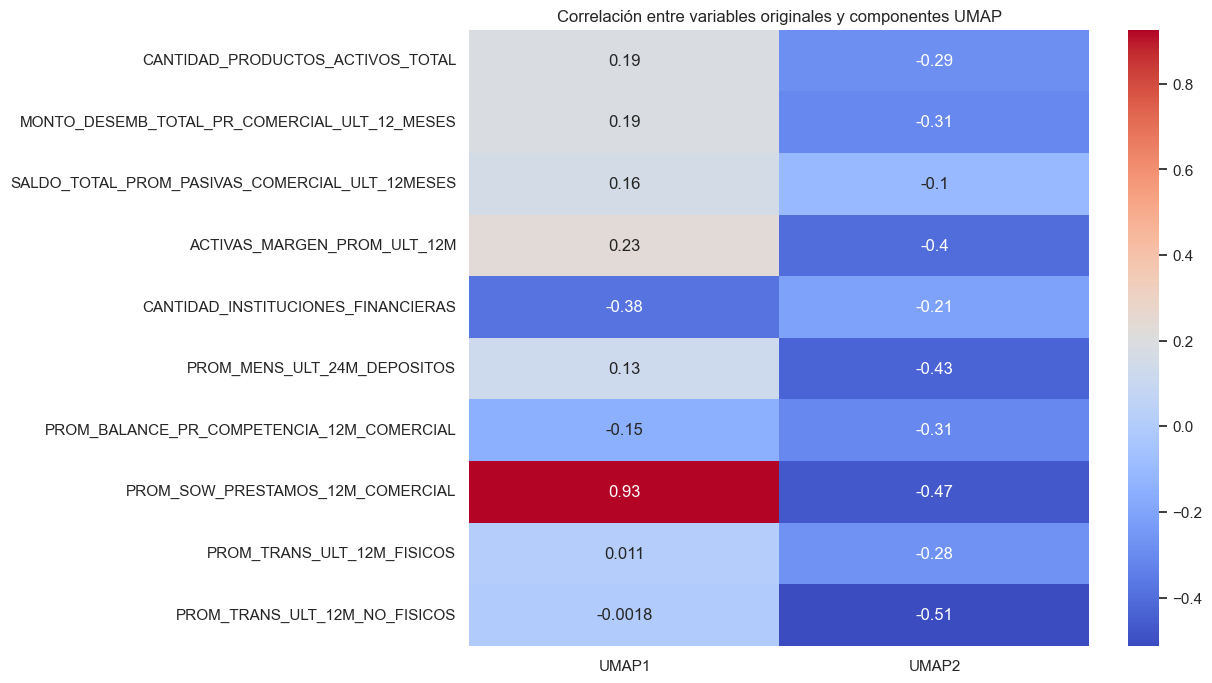

In [90]:
# Concatenamos las variables originales y las componentes UMAP
combined_df = pd.concat([df_ml_scaled[columns_to_scale].reset_index(drop=True), umap_df], axis=1)

# Calculamos la correlación entre las variables originales y las componentes UMAP
corr_matrix = combined_df.corr().loc[columns_to_scale, ['UMAP1', 'UMAP2']]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlación entre variables originales y componentes UMAP')
plt.show()

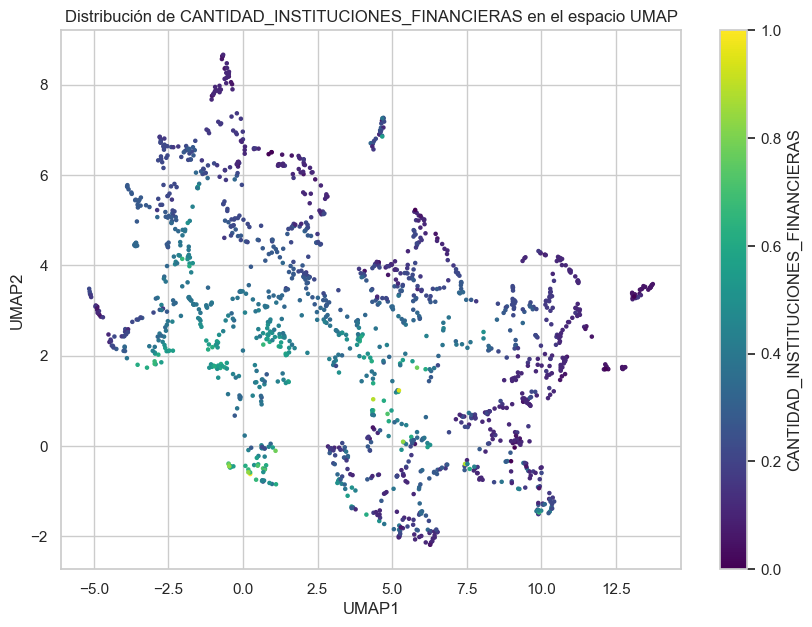

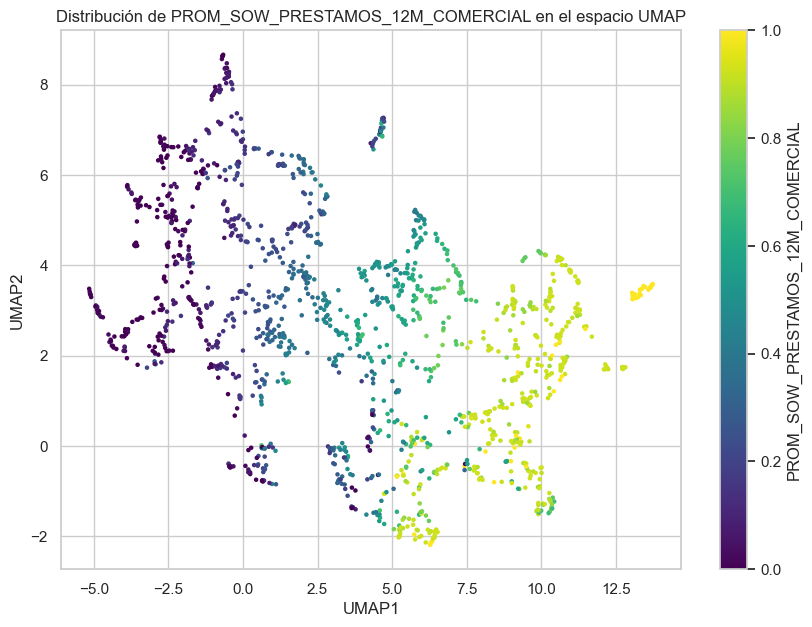

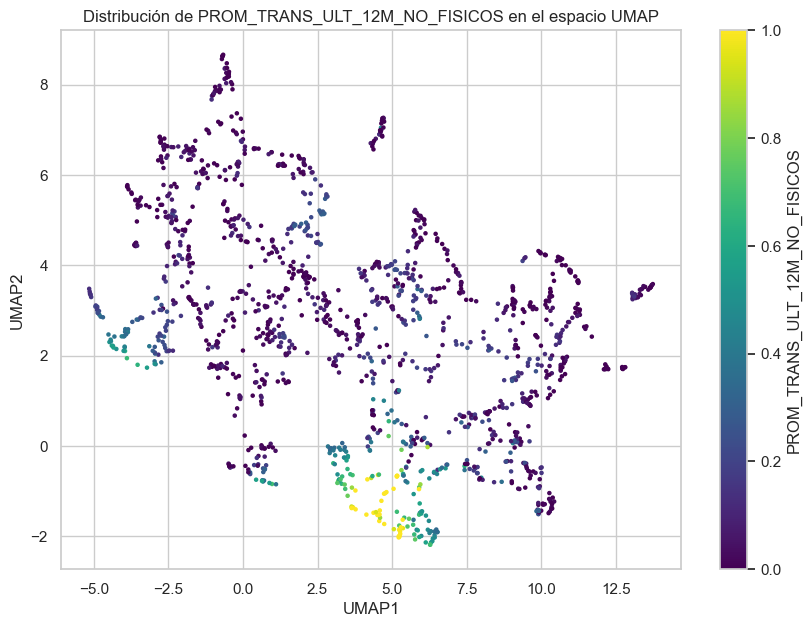

In [91]:
# Seleccionamos las variables más correlacionadas con UMAP1 y UMAP2
top_vars_umap1 = corr_matrix['UMAP1'].abs().sort_values(ascending=False).head(2).index
top_vars_umap2 = corr_matrix['UMAP2'].abs().sort_values(ascending=False).head(2).index

# Función para visualizar la distribución
def plot_umap_with_variable(variable):
    plt.figure(figsize=(10, 7))
    plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c=df_ml_scaled[variable], cmap='viridis', s=5)
    plt.colorbar(label=variable)
    plt.title(f'Distribución de {variable} en el espacio UMAP')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.show()

# Visualizamos las variables más influyentes
for var in top_vars_umap1.union(top_vars_umap2):
    plot_umap_with_variable(var)

In [92]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

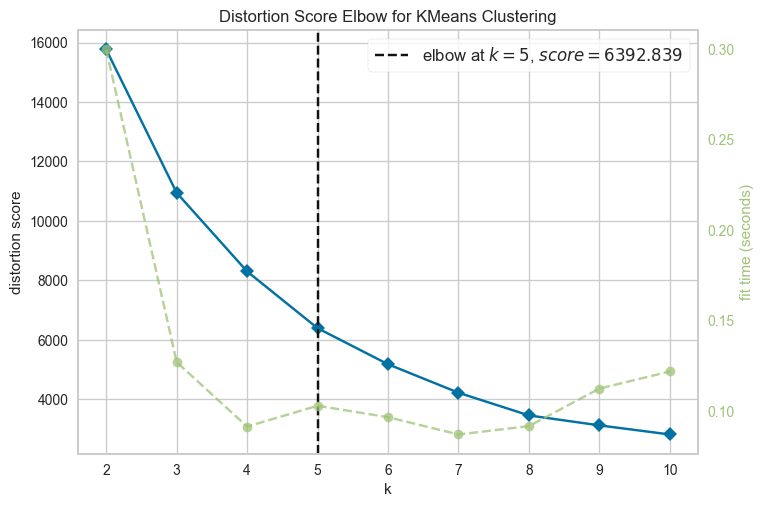

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [93]:
# Inicializar el modelo de KMeans
model = KMeans(n_init=10, random_state=0, max_iter=150, init='k-means++', algorithm='elkan')

# Inicializar el visualizador del método del codo con el rango de clusters
visualizer = KElbowVisualizer(model, k=(2, 11), timings=True)

# Ajustar el visualizador con tus datos (excluyendo 'CODIGO_CLIENTE')
visualizer.fit(data_umap)  

# Visualizar el gráfico del codo
visualizer.show()

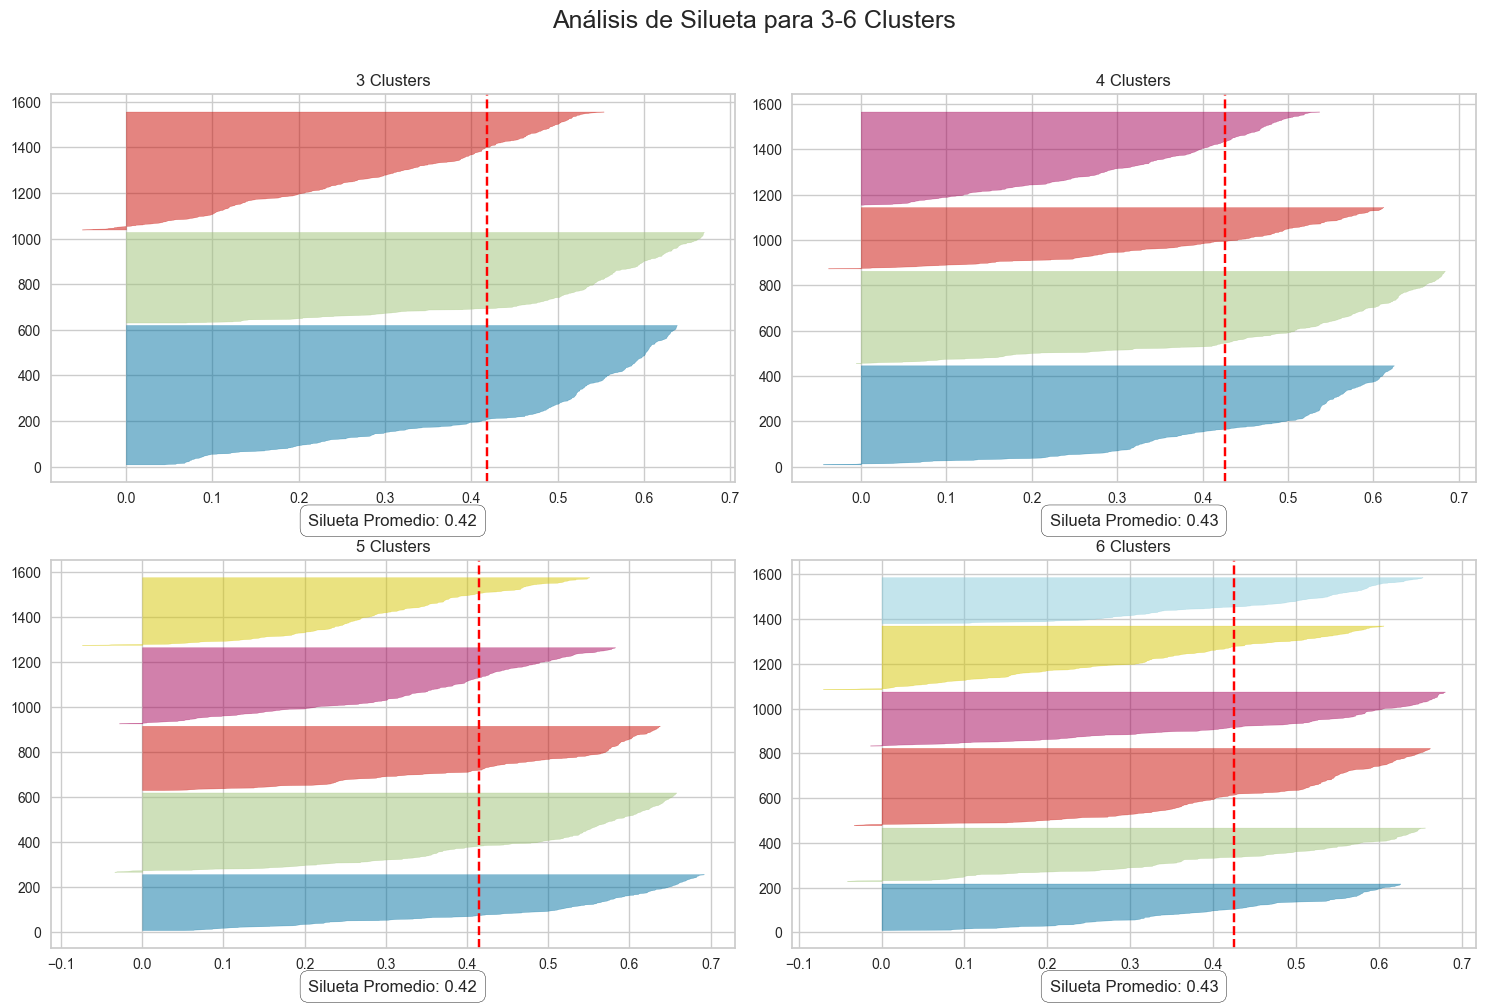

In [94]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt

# Parámetros
num_clusters_min = 3
num_clusters_max = 6

# Configurar el gráfico con subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))  # Ajusta la figura para 4 subplots (2 filas, 2 columnas)
fig.suptitle('Análisis de Silueta para 3-6 Clusters', size=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajusta para dejar espacio para el título

# Bucle para crear el visualizador de silueta para diferentes números de clusters
for i, num_clusters in enumerate(range(num_clusters_min, num_clusters_max + 1)):
    # Crear instancia de KMeans para el número actual de clusters
    km = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, max_iter=100, random_state=42)
    
    # Crear instancia de SilhouetteVisualizer con la instancia de KMeans
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[i // 2][i % 2])
    
    # Ajustar el visualizador
    visualizer.fit(data_umap)
    
    # Extraer el puntaje de silueta promedio
    silhouette_score = visualizer.silhouette_score_
    
    # Configurar título y puntaje de silueta para cada subplot
    ax[i // 2][i % 2].set_title(f'{num_clusters} Clusters')
    ax[i // 2][i % 2].text(0.5, -0.1, f'Silueta Promedio: {silhouette_score:.2f}', 
                           horizontalalignment='center', 
                           verticalalignment='center', 
                           transform=ax[i // 2][i % 2].transAxes, 
                           fontsize=12, 
                           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')) 

# Ajustar el espacio entre subplots
plt.subplots_adjust(hspace=0.2)

# Ajustar la visualización
plt.show()

In [95]:
#Paramatros
nro_clusters = 3

# Ajustar el modelo KMeans con el número óptimo de clusters
kmeans = KMeans(n_clusters=nro_clusters, n_init=10, random_state=0, max_iter=100, init='k-means++', algorithm='elkan')
df_ml_scaled['Cluster'] = kmeans.fit_predict(data_umap)

In [96]:
columns_to_scale

Index(['CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL',
       'MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES',
       'SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES',
       'ACTIVAS_MARGEN_PROM_ULT_12M', 'CANTIDAD_INSTITUCIONES_FINANCIERAS',
       'PROM_MENS_ULT_24M_DEPOSITOS',
       'PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL',
       'PROM_SOW_PRESTAMOS_12M_COMERCIAL', 'PROM_TRANS_ULT_12M_FISICOS',
       'PROM_TRANS_ULT_12M_NO_FISICOS'],
      dtype='object')

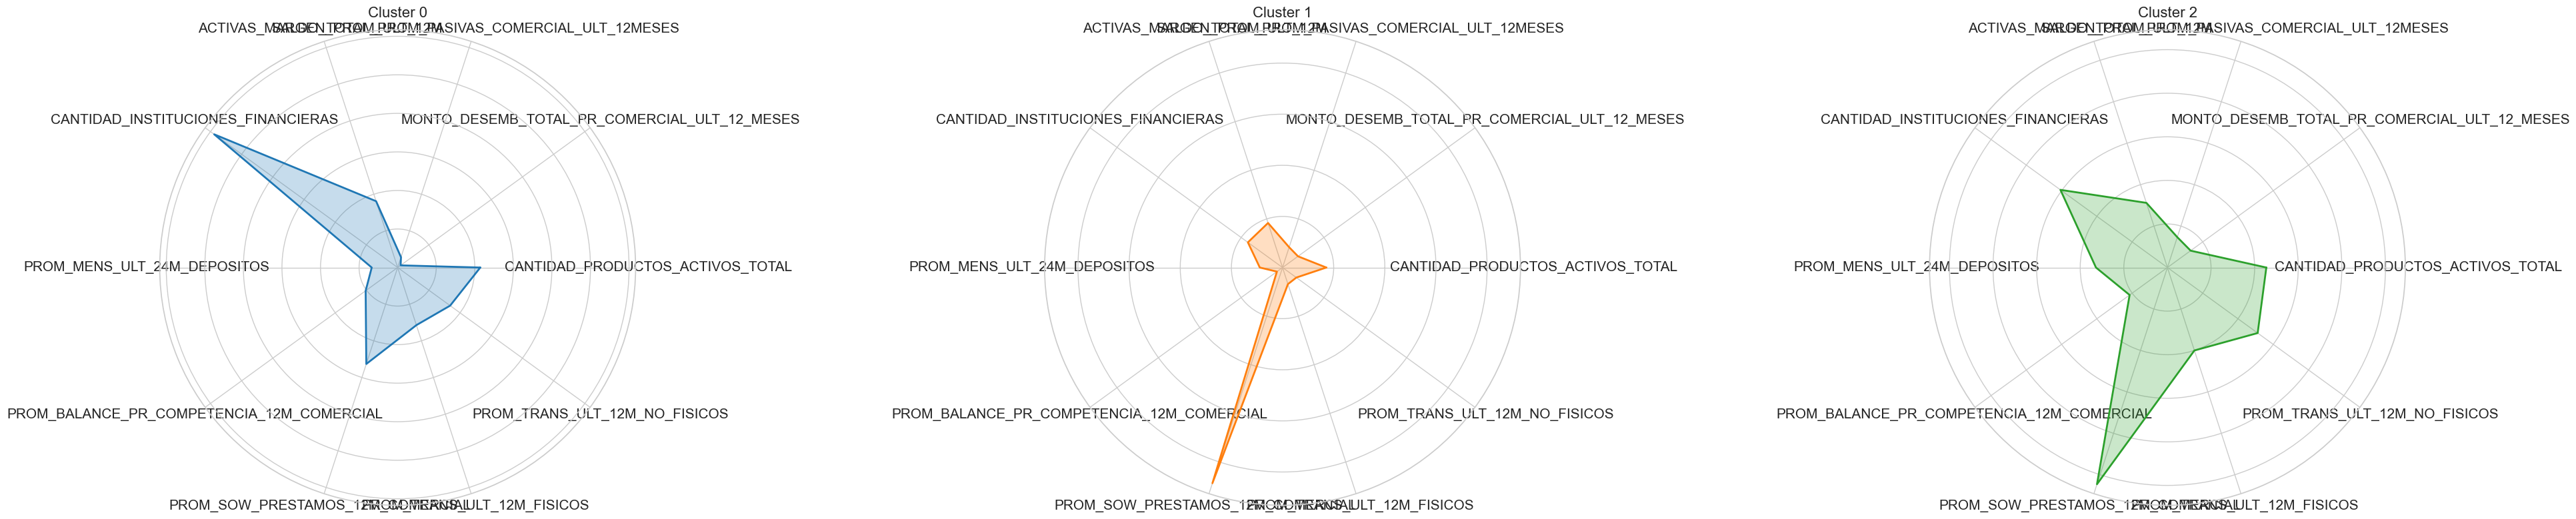

In [97]:
# Número de características 
num_vars = len(columns_to_scale)

# Calcular el promedio de cada característica por cluster
cluster_means = df_ml_scaled.groupby('Cluster')[columns_to_scale].mean()

# Configurar el gráfico de radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Cerrar el gráfico de radar
cluster_means = cluster_means.values
cluster_means = np.concatenate((cluster_means, cluster_means[:, [0]]), axis=1)
angles += angles[:1]

# Colores para los clusters
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Inicializar la figura con subgráficos (ajustar el tamaño aquí)
fig, axs = plt.subplots(1, len(cluster_means), figsize=(40, 8), subplot_kw=dict(polar=True))

# Crear el gráfico de radar para cada cluster
for i in range(len(cluster_means)):
    # Dibujar el cluster actual
    axs[i].fill(angles, cluster_means[i], color=colors[i % len(colors)], alpha=0.25)
    axs[i].plot(angles, cluster_means[i], color=colors[i % len(colors)], linewidth=2)
    
    # Configurar etiquetas
    axs[i].set_xticks(angles[:-1])
    axs[i].set_xticklabels(columns_to_scale, fontsize=15)  # Aumentar el tamaño de la fuente

    # Ocultar los valores en el gráfico
    axs[i].set_yticklabels([])  # Esto oculta las etiquetas de los valores en el eje radial
    
    axs[i].set_title(f'Cluster {i}', size=16)  # Ajustar el tamaño del título

# Ajustar el layout
plt.tight_layout()
plt.show()

#### 03.4. Importancia Variables

Precisión del modelo Random Forest: 1.0000


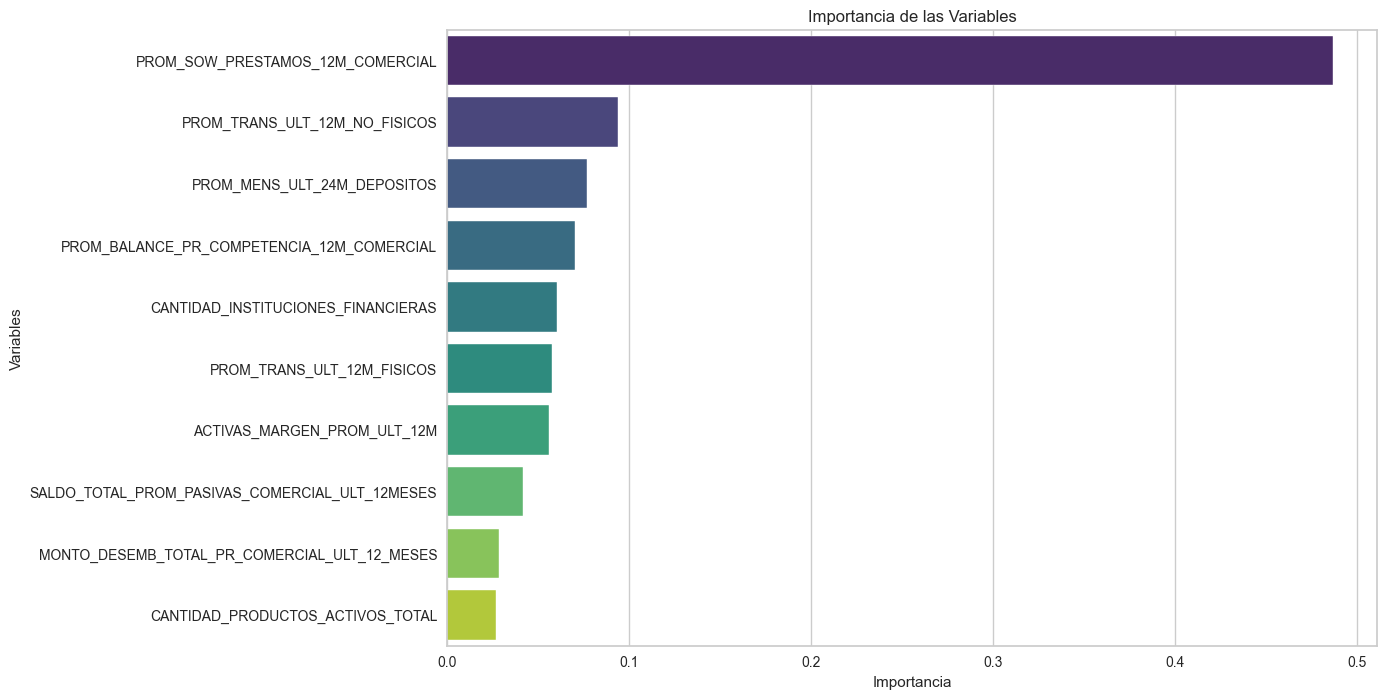

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Entrenar un modelo Random Forest para evaluar la importancia de las variables
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(df_ml_scaled[columns_to_scale], df_ml_scaled['Cluster'])

# Calcular la precisión del modelo
y_pred = rf.predict(df_ml_scaled[columns_to_scale])
accuracy = accuracy_score(df_ml_scaled['Cluster'], y_pred)
print(f'Precisión del modelo Random Forest: {accuracy:.4f}')

# Visualizar la importancia de las variables
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
sns.barplot(y=df_ml_scaled[columns_to_scale].columns[indices], x=importances[indices], palette="viridis")
plt.title('Importancia de las Variables')
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.show()

In [99]:
volumetria(df_ml_scaled, 'Cluster', 1)

,Cluster,Cantidad,% Total,% Acumulado
0,0,612,40.05,40.05
1,1,398,26.05,66.10
2,2,518,33.90,100.00


In [100]:
df_final = df_ml.merge(df_ml_scaled[['CUSTOMER_SK', 'Cluster']], how='inner', on = ['CUSTOMER_SK'])

df_final

,CUSTOMER_SK,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,ACTIVAS_MARGEN_PROM_ULT_12M,CANTIDAD_INSTITUCIONES_FINANCIERAS,PROM_MENS_ULT_24M_DEPOSITOS,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,PROM_SOW_PRESTAMOS_12M_COMERCIAL,PROM_TRANS_ULT_12M_FISICOS,PROM_TRANS_ULT_12M_NO_FISICOS,Cluster
0,2851211,1,0.00,0.00,"7,133.48",2.00,0.00,0.00,22.49,9.50,0.00,0
1,548918,2,0.00,0.00,711.38,2.00,"332,107.12",0.00,13.73,41.08,9.75,0
2,480465,3,0.00,22.44,"-5,934.02",6.00,"48,887.12",0.00,20.10,103.58,0.08,0
3,186465,7,0.00,"10,220,109.66","2,373.75",3.00,"1,275,587.76",0.00,53.55,28.59,34.08,2
4,1540579,7,0.00,"2,656,071.49",38.80,3.00,"2,071,641.57",0.00,14.95,2.42,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1523,4223322,2,0.00,0.00,"1,654.38",2.00,"27,979.10","6,124,468.66",8.18,0.33,0.00,0
1524,4388996,2,0.00,"5,254,532.91","4,562.77",2.00,"9,444,339.13","193,053.23",92.31,2.58,0.00,1
1525,5159218,1,0.00,"411,912.94",201.17,3.00,"539,836.02","667,923.25",58.33,2.58,3.42,2
1526,4676307,9,0.00,"708,632.71","41,351.73",8.00,"2,027,274.75","6,225,767.46",74.35,18.50,23.08,2


In [101]:
df_agrupado_01 = df_final.groupby('Cluster').agg(
    NRO_CLIENTES=('CUSTOMER_SK', 'count'),
).reset_index()

df_agrupado_01

,Cluster,NRO_CLIENTES
0,0,612
1,1,398
2,2,518


In [102]:
df_agrupado_02 = df_final.drop(columns = ['CUSTOMER_SK']).groupby('Cluster').mean().reset_index()
df_agrupado_02

,Cluster,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,ACTIVAS_MARGEN_PROM_ULT_12M,CANTIDAD_INSTITUCIONES_FINANCIERAS,PROM_MENS_ULT_24M_DEPOSITOS,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,PROM_SOW_PRESTAMOS_12M_COMERCIAL,PROM_TRANS_ULT_12M_FISICOS,PROM_TRANS_ULT_12M_NO_FISICOS
0,0,4.11,"2,171,959.54","4,890,193.07","10,112.34",5.29,"6,046,826.13","25,646,103.16",13.16,31.07,13.92
1,1,5.96,"33,991,913.65","28,988,496.18","73,731.83",3.02,"15,997,387.25","13,569,630.23",88.74,26.99,11.04
2,2,7.58,"29,951,785.54","25,408,802.22","55,004.82",5.46,"29,483,877.36","53,600,541.83",52.28,79.13,42.34


In [103]:
df_estadisticos = df_agrupado_01.merge(df_agrupado_02, how='left', on = ['Cluster'])
df_estadisticos

,Cluster,NRO_CLIENTES,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,ACTIVAS_MARGEN_PROM_ULT_12M,CANTIDAD_INSTITUCIONES_FINANCIERAS,PROM_MENS_ULT_24M_DEPOSITOS,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,PROM_SOW_PRESTAMOS_12M_COMERCIAL,PROM_TRANS_ULT_12M_FISICOS,PROM_TRANS_ULT_12M_NO_FISICOS
0,0,612,4.11,"2,171,959.54","4,890,193.07","10,112.34",5.29,"6,046,826.13","25,646,103.16",13.16,31.07,13.92
1,1,398,5.96,"33,991,913.65","28,988,496.18","73,731.83",3.02,"15,997,387.25","13,569,630.23",88.74,26.99,11.04
2,2,518,7.58,"29,951,785.54","25,408,802.22","55,004.82",5.46,"29,483,877.36","53,600,541.83",52.28,79.13,42.34


In [104]:
df_final_01 = df_04.merge(df_final[['CUSTOMER_SK', 'Cluster']], how='inner', on = ['CUSTOMER_SK'])

# Crear un diccionario de mapeo para renombrar los clusters
mapeo_clusters = {0: 'ACT_00', 1: 'ACT_01', 2: 'ACT_02', 3: 'ACT_03', 4: 'N1_04'}

# Aplicar el mapeo a la columna 'Cluster'
df_final_01['Cluster'] = df_final_01['Cluster'].map(mapeo_clusters)

#R esumen Data
print(f'Nro Clientes: {df_final_01["CUSTOMER_SK"].nunique():,}')
print(f'Nro Columnas: {df_final_01.shape[1]:,}')
print(f'Nro Filas: {df_final_01.shape[0]:,}')
df_final_01.head(5)

Nro Clientes: 1,528
Nro Columnas: 54
Nro Filas: 1,528


,CUSTOMER_SK,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,CANTIDAD_PRODUCTOS_ACTIVOS_UNICOS,ANTIGUEDAD_CLIENTE_DIAS,MONTO_DESEMB_PROM_PR_COMERCIAL_ULT_12_MESES,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,CANTIDAD_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,DEUDA_TOTAL_COMERCIAL,SALDO_TOTAL_PROM_ACTIVAS_COMERCIAL_ULT_12MESES,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,ACTIVAS_MARGEN_PROM_ULT_12M,PASIVAS_MARGEN_PROM_ULT_12M,CANTIDAD_ACTIVAS_SIS_FINANCIERO,CANTIDAD_INSTITUCIONES_FINANCIERAS,TOTAL_DESEMB_PR_SIST_FINANC,TOTAL_ADEUDADO_TC_SIST_FINANC,SALDO_TOTAL_ACTIVAS_COMERCIAL_ULT_12MESES,SUM_BP_BRRD_ULT_12M_CA,PROM_BP_BRRD_ULT_12M_CA,SUM_BP_BRRD_ULT_12M_CC,PROM_BP_BRRD_ULT_12M_CC,SUM_BP_BRRD_ULT_12M_CD,PROM_BP_BRRD_ULT_12M_CD,MAX_DIAS_ATRASO_PR,PROM_TRANS_ULT_12M_TUBANCO,PROM_TRANS_ULT_12M_APP,PROM_TRANS_ULT_12M_SAB,PROM_TRANS_ULT_12M_IVR,PROM_TRANS_ULT_12M_M960,PROM_TRANS_ULT_12M_TPAGO,PROM_TRANS_ULT_12M_ATM,PROM_TRANS_ULT_12M_POS,PROM_TRANS_ULT_12M_CAJA,PROM_MENS_ULT_24M_DEPOSITOS,PROM_MENS_LC_TARJETA_CREDITO_ULT_12M,CODIGO_CIU,CIU,CODIGO_SECTOR,SECTOR_ECONOMICO,SUM_GANANCIAS_12M,SUM_PROVISION_CONSTITUIDA_12M,SUM_COMISIONES_12M,PROM_SCORE_INTERNO,PROM_BALANCE_PR_BANRESERVAS_12M_COMERCIAL,PROM_BALANCE_TC_BANRESERVAS_12M_COMERCIAL,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,PROM_BALANCE_TC_COMPETENCIA_12M_COMERCIAL,PROM_SOW_PRESTAMOS_12M_COMERCIAL,PROM_SOW_TC_12M_COMERCIAL,PROM_SOW_TOTAL_12M_COMERCIAL,INDES_ULT_6_MES,PROM_TRANS_ULT_12M_FISICOS,PROM_TRANS_ULT_12M_NO_FISICOS,Cluster
0,2851211,1,1,3553,NaN,NaN,NaN,NaN,"73,273.23",0.00,"7,133.48",0.00,5.00,2.00,0.00,"577,079.90",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0,0,0,0.00,9.50,0.00,NaN,"344,985.00","930,000.00",Servicios N. C. P.,O,"Otras actividades de servicios comunitarios, sociales y personales",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.49,NaN,NaN,NaN,9.50,0.00,ACT_00
1,548918,2,2,3871,NaN,NaN,NaN,NaN,"31,916.65",0.00,711.38,"8,344.39",5.00,2.00,0.00,"39,416.00",NaN,"12,729,181.36","1,060,765.11",NaN,NaN,NaN,NaN,NaN,5.75,4.00,0.33,0,0,0,1.75,34.83,4.50,"332,107.12","59,332.00","950,004.00",Empleados (asalariados),P,"Actividades de los hogares en calidad de empleadores, actividades indiferenciadas de producción de bienes y servicios de los hogares para uso propio","101,332.83",580.48,"46,789.13",NaN,NaN,NaN,NaN,NaN,13.73,NaN,NaN,NaN,41.08,9.75,ACT_00
2,480465,3,3,3871,NaN,NaN,NaN,NaN,"212,086.11",22.44,"-5,934.02",40.12,15.00,6.00,"13,766,139.00","1,641,311.71",NaN,"44,272.67","3,689.39","24,125.86","8,041.95",NaN,NaN,NaN,0.08,0.00,0.00,0,0,0,0.00,103.25,0.33,"48,887.12","263,343.00","503,102.00",Venta de llantas de goma y tubos,G,Comercio al por mayor y al por menor,"-18,028.91","4,743.27","108,329.70",NaN,NaN,NaN,NaN,NaN,20.10,NaN,NaN,NaN,103.58,0.08,ACT_00
3,186465,7,4,3871,NaN,NaN,NaN,NaN,"12,221.35","10,220,109.66","2,373.75","11,448.82",8.00,3.00,"1,007,292.00","53,911.26",NaN,"740,747.78","25,543.03","2,677,444.93","223,120.41","120,036,172.57","5,001,507.19",NaN,2.83,31.25,0.00,0,0,0,7.67,19.00,1.92,"1,275,587.76","214,225.00","740,000.00",Otras actividades empresariales,K,"Actividades inmobiliarias, alquiler y actividades empresariales","175,103.79","8,954.94","63,502.15",NaN,NaN,NaN,NaN,NaN,53.55,NaN,NaN,NaN,28.59,34.08,ACT_02
4,1540579,7,3,3553,NaN,NaN,NaN,NaN,943.57,"2,656,071.49",38.80,993.98,9.00,3.00,"888,709.00","338,405.61",NaN,"182,489.26","26,069.89",NaN,NaN,"25,640,539.42","1,349,502.07",NaN,0.00,0.00,0.00,0,0,0,0.00,2.42,0.00,"2,071,641.57","197,507.00","740,000.00",Otras actividades empresariales,K,"Actividades inmobiliarias, alquiler y actividades empresariales",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.95,NaN,NaN,NaN,2.42,0.00,ACT_00


In [105]:
df_estadisticos.to_clipboard(index=False)

### Data Final

In [151]:
df_final_01.groupby(['Cluster']).agg(
    RECUENTO = ('CUSTOMER_SK', 'count'),
).reset_index()

,Cluster,RECUENTO
0,ACT_00,612
1,ACT_01,398
2,ACT_02,518


In [152]:
df_final_02.groupby(['Cluster']).agg(
    RECUENTO = ('CUSTOMER_SK', 'count'),
).reset_index()

,Cluster,RECUENTO
0,PAS_00,518
1,PAS_01,1332
2,PAS_02,1000


In [164]:
df_clusters = pd.concat([df_final_01, df_final_02], axis = 0)
# Resumen Data
print(f'Nro Clientes: {df_clusters["CUSTOMER_SK"].nunique():,}')
print(f'Nro Columnas: {df_clusters.shape[1]:,}')
print(f'Nro Filas: {df_clusters.shape[0]:,}')
df_clusters.head()

Nro Clientes: 4,378
Nro Columnas: 54
Nro Filas: 4,378


,CUSTOMER_SK,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,CANTIDAD_PRODUCTOS_ACTIVOS_UNICOS,ANTIGUEDAD_CLIENTE_DIAS,MONTO_DESEMB_PROM_PR_COMERCIAL_ULT_12_MESES,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,CANTIDAD_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,DEUDA_TOTAL_COMERCIAL,SALDO_TOTAL_PROM_ACTIVAS_COMERCIAL_ULT_12MESES,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,ACTIVAS_MARGEN_PROM_ULT_12M,PASIVAS_MARGEN_PROM_ULT_12M,CANTIDAD_ACTIVAS_SIS_FINANCIERO,CANTIDAD_INSTITUCIONES_FINANCIERAS,TOTAL_DESEMB_PR_SIST_FINANC,TOTAL_ADEUDADO_TC_SIST_FINANC,SALDO_TOTAL_ACTIVAS_COMERCIAL_ULT_12MESES,SUM_BP_BRRD_ULT_12M_CA,PROM_BP_BRRD_ULT_12M_CA,SUM_BP_BRRD_ULT_12M_CC,PROM_BP_BRRD_ULT_12M_CC,SUM_BP_BRRD_ULT_12M_CD,PROM_BP_BRRD_ULT_12M_CD,MAX_DIAS_ATRASO_PR,PROM_TRANS_ULT_12M_TUBANCO,PROM_TRANS_ULT_12M_APP,PROM_TRANS_ULT_12M_SAB,PROM_TRANS_ULT_12M_IVR,PROM_TRANS_ULT_12M_M960,PROM_TRANS_ULT_12M_TPAGO,PROM_TRANS_ULT_12M_ATM,PROM_TRANS_ULT_12M_POS,PROM_TRANS_ULT_12M_CAJA,PROM_MENS_ULT_24M_DEPOSITOS,PROM_MENS_LC_TARJETA_CREDITO_ULT_12M,CODIGO_CIU,CIU,CODIGO_SECTOR,SECTOR_ECONOMICO,SUM_GANANCIAS_12M,SUM_PROVISION_CONSTITUIDA_12M,SUM_COMISIONES_12M,PROM_SCORE_INTERNO,PROM_BALANCE_PR_BANRESERVAS_12M_COMERCIAL,PROM_BALANCE_TC_BANRESERVAS_12M_COMERCIAL,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,PROM_BALANCE_TC_COMPETENCIA_12M_COMERCIAL,PROM_SOW_PRESTAMOS_12M_COMERCIAL,PROM_SOW_TC_12M_COMERCIAL,PROM_SOW_TOTAL_12M_COMERCIAL,INDES_ULT_6_MES,PROM_TRANS_ULT_12M_FISICOS,PROM_TRANS_ULT_12M_NO_FISICOS,Cluster
0,2851211,1,1,3553,NaN,NaN,NaN,NaN,"73,273.23",0.00,"7,133.48",0.00,5.00,2.00,0.00,"577,079.90",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0,0,0,0.00,9.50,0.00,NaN,"344,985.00","930,000.00",Servicios N. C. P.,O,"Otras actividades de servicios comunitarios, sociales y personales",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.49,NaN,NaN,NaN,9.50,0.00,ACT_00
1,548918,2,2,3871,NaN,NaN,NaN,NaN,"31,916.65",0.00,711.38,"8,344.39",5.00,2.00,0.00,"39,416.00",NaN,"12,729,181.36","1,060,765.11",NaN,NaN,NaN,NaN,NaN,5.75,4.00,0.33,0,0,0,1.75,34.83,4.50,"332,107.12","59,332.00","950,004.00",Empleados (asalariados),P,"Actividades de los hogares en calidad de empleadores, actividades indiferenciadas de producción de bienes y servicios de los hogares para uso propio","101,332.83",580.48,"46,789.13",NaN,NaN,NaN,NaN,NaN,13.73,NaN,NaN,NaN,41.08,9.75,ACT_00
2,480465,3,3,3871,NaN,NaN,NaN,NaN,"212,086.11",22.44,"-5,934.02",40.12,15.00,6.00,"13,766,139.00","1,641,311.71",NaN,"44,272.67","3,689.39","24,125.86","8,041.95",NaN,NaN,NaN,0.08,0.00,0.00,0,0,0,0.00,103.25,0.33,"48,887.12","263,343.00","503,102.00",Venta de llantas de goma y tubos,G,Comercio al por mayor y al por menor,"-18,028.91","4,743.27","108,329.70",NaN,NaN,NaN,NaN,NaN,20.10,NaN,NaN,NaN,103.58,0.08,ACT_00
3,186465,7,4,3871,NaN,NaN,NaN,NaN,"12,221.35","10,220,109.66","2,373.75","11,448.82",8.00,3.00,"1,007,292.00","53,911.26",NaN,"740,747.78","25,543.03","2,677,444.93","223,120.41","120,036,172.57","5,001,507.19",NaN,2.83,31.25,0.00,0,0,0,7.67,19.00,1.92,"1,275,587.76","214,225.00","740,000.00",Otras actividades empresariales,K,"Actividades inmobiliarias, alquiler y actividades empresariales","175,103.79","8,954.94","63,502.15",NaN,NaN,NaN,NaN,NaN,53.55,NaN,NaN,NaN,28.59,34.08,ACT_02
4,1540579,7,3,3553,NaN,NaN,NaN,NaN,943.57,"2,656,071.49",38.80,993.98,9.00,3.00,"888,709.00","338,405.61",NaN,"182,489.26","26,069.89",NaN,NaN,"25,640,539.42","1,349,502.07",NaN,0.00,0.00,0.00,0,0,0,0.00,2.42,0.00,"2,071,641.57","197,507.00","740,000.00",Otras actividades empresariales,K,"Actividades inmobiliarias, alquiler y actividades empresariales",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.95,NaN,NaN,NaN,2.42,0.00,ACT_00


In [180]:
df_bal_01 = df_clusters.groupby(['Cluster']).agg(
    RECUENTO = ('CUSTOMER_SK', 'count'),
    ### VINCULACION
    TOTAL_DESEMB_PR_SIST_FINANC = ('TOTAL_DESEMB_PR_SIST_FINANC', 'sum'),
    MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES = ('MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES', 'sum'),
    SALDO_TOTAL_PROM_ACTIVAS_COMERCIAL_ULT_12MESES = ('SALDO_TOTAL_PROM_ACTIVAS_COMERCIAL_ULT_12MESES', 'mean'),
    PROM_SOW_PRESTAMOS_12M_COMERCIAL = ('PROM_SOW_PRESTAMOS_12M_COMERCIAL', 'mean'),
    # TASA PONDERADA - CORTE ULTIMO MES
    SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES = ('SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES', 'mean'), ## Talvez

    ### RENTABILIDAD
    ACTIVAS_MARGEN_PROM_ULT_12M = ('ACTIVAS_MARGEN_PROM_ULT_12M', 'mean'),
    PASIVAS_MARGEN_PROM_ULT_12M = ('PASIVAS_MARGEN_PROM_ULT_12M', 'mean'),

    ### COMPORTAMENTAL
    CANTIDAD_INSTITUCIONES_FINANCIERAS = ('CANTIDAD_INSTITUCIONES_FINANCIERAS', 'mean'),
    PROM_TRANS_ULT_12M_FISICOS = ('PROM_TRANS_ULT_12M_FISICOS', 'mean'),
    PROM_TRANS_ULT_12M_NO_FISICOS = ('PROM_TRANS_ULT_12M_NO_FISICOS', 'mean'),
    # SCORE RIESGO - CORTE ULTIMO MES

    ### POTENCIAL
    PROM_MENS_ULT_24M_DEPOSITOS = ('PROM_MENS_ULT_24M_DEPOSITOS', 'mean'),
    PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL = ('PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL', 'mean'),
    #SUM_BALANCE_PR_COMPETENCIA_ULT_CORTE = ('BALANCE_PR_COMPETENCIA_202409', 'sum'),

    ### Adicionales
    RECUENTO_TU = ('RECUENTO_TU', 'sum'),
    SCORE2_TU = ('SCORE2_TU', 'mean'),
    NRO_DESEMBOLSOS = ('NRO_DESEMBOLSOS', 'sum'),
    TASA_PONDERADA = ('TASA_PONDERADA', 'mean'),
    
    CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL =('CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL', 'mean'),
    CANTIDAD_PRODUCTOS_ACTIVOS_UNICOS =('CANTIDAD_PRODUCTOS_ACTIVOS_UNICOS', 'mean'),
    ANTIGUEDAD_CLIENTE_DIAS = ('ANTIGUEDAD_CLIENTE_DIAS', 'mean'),
    MONTO_DESEMB_PROM_PR_COMERCIAL_ULT_12_MESES = ('MONTO_DESEMB_PROM_PR_COMERCIAL_ULT_12_MESES', 'mean'),
    CANTIDAD_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES = ('CANTIDAD_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES', 'mean'),
    CANTIDAD_ACTIVAS_SIS_FINANCIERO = ('CANTIDAD_ACTIVAS_SIS_FINANCIERO', 'mean'),
    PROM_BP_BRRD_ULT_12M_CA = ('PROM_BP_BRRD_ULT_12M_CA', 'mean'),
    PROM_BP_BRRD_ULT_12M_CC = ('PROM_BP_BRRD_ULT_12M_CC', 'mean'),
    PROM_BP_BRRD_ULT_12M_CD = ('PROM_BP_BRRD_ULT_12M_CD', 'mean'),
    MAX_DIAS_ATRASO_PR = ('MAX_DIAS_ATRASO_PR', 'mean'),
    PROM_TRANS_ULT_12M_TUBANCO = ('PROM_TRANS_ULT_12M_TUBANCO', 'mean'),
    PROM_TRANS_ULT_12M_APP = ('PROM_TRANS_ULT_12M_APP', 'mean'),
    PROM_TRANS_ULT_12M_SAB = ('PROM_TRANS_ULT_12M_SAB', 'mean'),
    PROM_TRANS_ULT_12M_ATM = ('PROM_TRANS_ULT_12M_ATM', 'mean'),
    PROM_TRANS_ULT_12M_POS = ('PROM_TRANS_ULT_12M_POS', 'mean'),
    PROM_TRANS_ULT_12M_CAJA = ('PROM_TRANS_ULT_12M_CAJA', 'mean'),
    SUM_GANANCIAS_12M = ('SUM_GANANCIAS_12M', 'mean'),
    SUM_PROVISION_CONSTITUIDA_12M = ('SUM_PROVISION_CONSTITUIDA_12M', 'mean'),
    SUM_COMISIONES_12M = ('SUM_COMISIONES_12M', 'mean'),
    PROM_BALANCE_PR_BANRESERVAS_12M_COMERCIAL = ('PROM_BALANCE_PR_BANRESERVAS_12M_COMERCIAL', 'mean'),
    
    TOTAL_BALANCE_PR_COMPETENCIA_12M_COMERCIAL = ('PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL', 'sum'),
).reset_index()

df_bal_01

,Cluster,RECUENTO,TOTAL_DESEMB_PR_SIST_FINANC,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,SALDO_TOTAL_PROM_ACTIVAS_COMERCIAL_ULT_12MESES,PROM_SOW_PRESTAMOS_12M_COMERCIAL,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,ACTIVAS_MARGEN_PROM_ULT_12M,PASIVAS_MARGEN_PROM_ULT_12M,CANTIDAD_INSTITUCIONES_FINANCIERAS,PROM_TRANS_ULT_12M_FISICOS,PROM_TRANS_ULT_12M_NO_FISICOS,PROM_MENS_ULT_24M_DEPOSITOS,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,RECUENTO_TU,SCORE2_TU,NRO_DESEMBOLSOS,TASA_PONDERADA,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,CANTIDAD_PRODUCTOS_ACTIVOS_UNICOS,ANTIGUEDAD_CLIENTE_DIAS,MONTO_DESEMB_PROM_PR_COMERCIAL_ULT_12_MESES,CANTIDAD_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,CANTIDAD_ACTIVAS_SIS_FINANCIERO,PROM_BP_BRRD_ULT_12M_CA,PROM_BP_BRRD_ULT_12M_CC,PROM_BP_BRRD_ULT_12M_CD,MAX_DIAS_ATRASO_PR,PROM_TRANS_ULT_12M_TUBANCO,PROM_TRANS_ULT_12M_APP,PROM_TRANS_ULT_12M_SAB,PROM_TRANS_ULT_12M_ATM,PROM_TRANS_ULT_12M_POS,PROM_TRANS_ULT_12M_CAJA,SUM_GANANCIAS_12M,SUM_PROVISION_CONSTITUIDA_12M,SUM_COMISIONES_12M,PROM_BALANCE_PR_BANRESERVAS_12M_COMERCIAL,TOTAL_BALANCE_PR_COMPETENCIA_12M_COMERCIAL
0,ACT_00,612,"16,986,905,511.92","1,329,239,236.16","5,575,119.59",13.16,"4,889,623.14","9,900.56","20,913.90",5.29,31.07,13.92,"6,046,826.13","25,646,103.16",11.00,759.18,160.00,12.46,4.11,2.64,"2,911.51","180,996.63",0.17,403.33,"1,210,647.16","1,840,772.41","1,664,371.28",1.29,11.06,2.87,0.00,0.18,15.14,15.75,"96,953.92","19,164.99","17,332.31","4,969,287.66","15,695,415,133.87"
1,ACT_01,398,"33,963,477,031.43","14,605,048,904.09","74,884,584.76",88.74,"33,757,532.42","74,276.98","64,175.24",3.02,26.99,11.04,"17,679,398.49","15,703,493.23",8.00,739.88,608.00,11.60,6.09,3.00,"2,516.91","3,058,008.56",1.08,262.95,"2,007,868.85","5,372,019.51","8,427,028.36",8.46,8.80,2.24,0.00,0.02,5.74,21.23,"239,350.78","119,399.10","11,757.52","69,931,585.88","6,249,990,304.34"
2,ACT_02,518,"110,135,420,425.38","17,098,725,099.11","50,710,745.59",52.28,"32,705,737.04","55,033.34","69,047.57",5.46,106.41,56.82,"30,653,584.27","82,403,916.89",19.00,755.95,"1,186.00",11.38,8.22,3.19,"2,974.91","2,750,760.15",1.65,596.13,"2,649,911.98","4,751,028.80","6,224,483.46",2.20,50.12,6.70,1.85,0.26,19.58,86.58,"224,297.32","43,406.79","26,643.59","45,250,245.11","42,685,228,948.62"
3,PAS_00,518,"7,538,854.00",0.00,-1.29,0.00,"124,308.30",8.41,792.68,0.00,0.83,0.52,"258,596.29","87,918.60",3.00,695.67,0.00,NaN,1.18,1.00,"2,261.23",0.00,0.00,0.00,"10,327.36","117,776.39","2,115.87",0.00,0.44,0.09,0.00,0.05,0.07,0.71,"19,423.26","5,624.89","3,360.57","411,226.44","45,541,837.10"
4,PAS_01,1332,"35,556,229,315.63",0.00,-277.59,0.00,"13,373,775.24",410.95,"40,123.78",1.73,22.54,12.73,"8,933,427.02","19,373,487.45",8.00,741.75,1.00,13.75,3.57,2.06,"2,274.75",0.00,0.00,111.69,"2,364,119.69","3,132,254.77","3,356,196.63",0.17,10.88,1.85,3.15,0.06,0.30,22.18,"85,919.58","9,945.07","6,120.33","168,007.57","25,805,485,277.39"
5,PAS_02,1000,"16,783,731,096.38",0.00,-98.13,0.00,"1,719,606.10",67.88,"9,759.20",2.56,8.11,4.56,"2,631,199.19","17,972,852.24",3.00,746.67,0.00,NaN,1.23,1.00,"2,756.87",0.00,0.00,185.13,"189,772.01","1,319,294.38","120,918.17",0.00,3.69,0.87,0.00,0.03,0.10,7.98,"8,507.10","16,366.39","4,716.95","85,462.88","17,972,852,238.97"


In [ ]:
df_clusters.to_csv('Output/df_clusters_emp.csv', sep=";", index=False, encoding='LATIN-1')